# Sciplex Dose

In [1]:
ood_seed = 0

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('BMS', '5.0'), 193)

Removed datapoint: 193


In [10]:
adata

AnnData object with n_obs × n_vars = 14618 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_ood-seed-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 15lad815
Name: star-womprat-259
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/15lad815
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_003019-15lad815/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1738,1576,1452,1712,1283,1526,1435,973
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1383,3584,2194,2796,1738
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 417,385,340,459,314,414,332,262
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 363,884,566,693,417
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:21<3:33:13, 21.36s/it]

Epoch 1/600:   0%|          | 1/600 [00:21<3:33:13, 21.36s/it, v_num=15_1, total_loss_train=2.67e+3, kl_local_train=30]

Epoch 2/600:   0%|          | 1/600 [00:21<3:33:13, 21.36s/it, v_num=15_1, total_loss_train=2.67e+3, kl_local_train=30]

Epoch 2/600:   0%|          | 2/600 [00:39<3:11:55, 19.26s/it, v_num=15_1, total_loss_train=2.67e+3, kl_local_train=30]

Epoch 2/600:   0%|          | 2/600 [00:39<3:11:55, 19.26s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=57.7]

Epoch 3/600:   0%|          | 2/600 [00:39<3:11:55, 19.26s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=57.7]

Epoch 3/600:   0%|          | 3/600 [01:00<3:22:25, 20.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=57.7]

Epoch 3/600:   0%|          | 3/600 [01:00<3:22:25, 20.34s/it, v_num=15_1, total_loss_train=2.22e+3, kl_local_train=64]  

Epoch 4/600:   0%|          | 3/600 [01:00<3:22:25, 20.34s/it, v_num=15_1, total_loss_train=2.22e+3, kl_local_train=64]

Epoch 4/600:   1%|          | 4/600 [01:18<3:12:55, 19.42s/it, v_num=15_1, total_loss_train=2.22e+3, kl_local_train=64]

Epoch 4/600:   1%|          | 4/600 [01:18<3:12:55, 19.42s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=65.2]

Epoch 5/600:   1%|          | 4/600 [01:18<3:12:55, 19.42s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=65.2]

Epoch 5/600:   1%|          | 5/600 [01:37<3:08:53, 19.05s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=65.2]

Epoch 5/600:   1%|          | 5/600 [01:37<3:08:53, 19.05s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=63.6]

Epoch 6/600:   1%|          | 5/600 [01:37<3:08:53, 19.05s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=63.6]

Epoch 6/600:   1%|          | 6/600 [01:53<2:59:02, 18.08s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=63.6]

Epoch 6/600:   1%|          | 6/600 [01:53<2:59:02, 18.08s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 7/600:   1%|          | 6/600 [01:53<2:59:02, 18.08s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 7/600:   1%|          | 7/600 [02:08<2:50:23, 17.24s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 7/600:   1%|          | 7/600 [02:08<2:50:23, 17.24s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 8/600:   1%|          | 7/600 [02:08<2:50:23, 17.24s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 8/600:   1%|▏         | 8/600 [02:24<2:45:57, 16.82s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 8/600:   1%|▏         | 8/600 [02:24<2:45:57, 16.82s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 9/600:   1%|▏         | 8/600 [02:24<2:45:57, 16.82s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 9/600:   2%|▏         | 9/600 [02:40<2:41:02, 16.35s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 9/600:   2%|▏         | 9/600 [02:40<2:41:02, 16.35s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 10/600:   2%|▏         | 9/600 [02:40<2:41:02, 16.35s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 10/600:   2%|▏         | 10/600 [02:56<2:39:58, 16.27s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 10/600:   2%|▏         | 10/600 [02:56<2:39:58, 16.27s/it, v_num=15_1, total_loss_train=2.18e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 11/600:   2%|▏         | 10/600 [02:56<2:39:58, 16.27s/it, v_num=15_1, total_loss_train=2.18e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 11/600:   2%|▏         | 11/600 [03:11<2:37:46, 16.07s/it, v_num=15_1, total_loss_train=2.18e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0291]

Epoch 11/600:   2%|▏         | 11/600 [03:11<2:37:46, 16.07s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]  

Epoch 12/600:   2%|▏         | 11/600 [03:11<2:37:46, 16.07s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 12/600:   2%|▏         | 12/600 [03:28<2:39:26, 16.27s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 12/600:   2%|▏         | 12/600 [03:28<2:39:26, 16.27s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 13/600:   2%|▏         | 12/600 [03:28<2:39:26, 16.27s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 13/600:   2%|▏         | 13/600 [03:44<2:38:35, 16.21s/it, v_num=15_1, total_loss_train=2.19e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 13/600:   2%|▏         | 13/600 [03:44<2:38:35, 16.21s/it, v_num=15_1, total_loss_train=2.2e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107] 

Epoch 14/600:   2%|▏         | 13/600 [03:44<2:38:35, 16.21s/it, v_num=15_1, total_loss_train=2.2e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 14/600:   2%|▏         | 14/600 [04:00<2:37:36, 16.14s/it, v_num=15_1, total_loss_train=2.2e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 14/600:   2%|▏         | 14/600 [04:00<2:37:36, 16.14s/it, v_num=15_1, total_loss_train=2.2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 15/600:   2%|▏         | 14/600 [04:00<2:37:36, 16.14s/it, v_num=15_1, total_loss_train=2.2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 15/600:   2%|▎         | 15/600 [04:17<2:39:51, 16.40s/it, v_num=15_1, total_loss_train=2.2e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 15/600:   2%|▎         | 15/600 [04:17<2:39:51, 16.40s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 16/600:   2%|▎         | 15/600 [04:18<2:39:51, 16.40s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 16/600:   3%|▎         | 16/600 [04:35<2:44:44, 16.93s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.049, metric_mi|condition_train=0.107]

Epoch 16/600:   3%|▎         | 16/600 [04:35<2:44:44, 16.93s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 17/600:   3%|▎         | 16/600 [04:35<2:44:44, 16.93s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 17/600:   3%|▎         | 17/600 [04:52<2:42:40, 16.74s/it, v_num=15_1, total_loss_train=2.21e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 17/600:   3%|▎         | 17/600 [04:52<2:42:40, 16.74s/it, v_num=15_1, total_loss_train=2.22e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 18/600:   3%|▎         | 17/600 [04:52<2:42:40, 16.74s/it, v_num=15_1, total_loss_train=2.22e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 18/600:   3%|▎         | 18/600 [05:07<2:37:27, 16.23s/it, v_num=15_1, total_loss_train=2.22e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 18/600:   3%|▎         | 18/600 [05:07<2:37:27, 16.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 19/600:   3%|▎         | 18/600 [05:07<2:37:27, 16.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 19/600:   3%|▎         | 19/600 [05:23<2:36:11, 16.13s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 19/600:   3%|▎         | 19/600 [05:23<2:36:11, 16.13s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 20/600:   3%|▎         | 19/600 [05:23<2:36:11, 16.13s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 20/600:   3%|▎         | 20/600 [05:40<2:40:26, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 20/600:   3%|▎         | 20/600 [05:40<2:40:26, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 21/600:   3%|▎         | 20/600 [05:41<2:40:26, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 21/600:   4%|▎         | 21/600 [05:57<2:40:06, 16.59s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.0551, metric_mi|condition_train=0.124]

Epoch 21/600:   4%|▎         | 21/600 [05:57<2:40:06, 16.59s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 22/600:   4%|▎         | 21/600 [05:57<2:40:06, 16.59s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 22/600:   4%|▎         | 22/600 [06:12<2:36:34, 16.25s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 22/600:   4%|▎         | 22/600 [06:12<2:36:34, 16.25s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 23/600:   4%|▎         | 22/600 [06:12<2:36:34, 16.25s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 23/600:   4%|▍         | 23/600 [06:28<2:34:09, 16.03s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 23/600:   4%|▍         | 23/600 [06:28<2:34:09, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 24/600:   4%|▍         | 23/600 [06:28<2:34:09, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 24/600:   4%|▍         | 24/600 [06:42<2:29:18, 15.55s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 24/600:   4%|▍         | 24/600 [06:42<2:29:18, 15.55s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 25/600:   4%|▍         | 24/600 [06:42<2:29:18, 15.55s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 25/600:   4%|▍         | 25/600 [06:59<2:32:21, 15.90s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 25/600:   4%|▍         | 25/600 [06:59<2:32:21, 15.90s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 26/600:   4%|▍         | 25/600 [06:59<2:32:21, 15.90s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 26/600:   4%|▍         | 26/600 [07:15<2:33:42, 16.07s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.114]

Epoch 26/600:   4%|▍         | 26/600 [07:15<2:33:42, 16.07s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=80, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]  

Epoch 27/600:   4%|▍         | 26/600 [07:15<2:33:42, 16.07s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=80, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 27/600:   4%|▍         | 27/600 [07:31<2:33:12, 16.04s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=80, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 27/600:   4%|▍         | 27/600 [07:31<2:33:12, 16.04s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 28/600:   4%|▍         | 27/600 [07:31<2:33:12, 16.04s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 28/600:   5%|▍         | 28/600 [07:47<2:32:18, 15.98s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=81.1, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 28/600:   5%|▍         | 28/600 [07:47<2:32:18, 15.98s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 29/600:   5%|▍         | 28/600 [07:47<2:32:18, 15.98s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 29/600:   5%|▍         | 29/600 [08:03<2:30:23, 15.80s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 29/600:   5%|▍         | 29/600 [08:03<2:30:23, 15.80s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 30/600:   5%|▍         | 29/600 [08:03<2:30:23, 15.80s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 30/600:   5%|▌         | 30/600 [08:19<2:33:14, 16.13s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=83.3, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 30/600:   5%|▌         | 30/600 [08:19<2:33:14, 16.13s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 31/600:   5%|▌         | 30/600 [08:20<2:33:14, 16.13s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 31/600:   5%|▌         | 31/600 [08:37<2:35:51, 16.44s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.112]

Epoch 31/600:   5%|▌         | 31/600 [08:37<2:35:51, 16.44s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 32/600:   5%|▌         | 31/600 [08:37<2:35:51, 16.44s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 32/600:   5%|▌         | 32/600 [08:52<2:34:01, 16.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=92.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 32/600:   5%|▌         | 32/600 [08:52<2:34:01, 16.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 33/600:   5%|▌         | 32/600 [08:52<2:34:01, 16.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 33/600:   6%|▌         | 33/600 [09:08<2:31:58, 16.08s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 33/600:   6%|▌         | 33/600 [09:08<2:31:58, 16.08s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=98.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 34/600:   6%|▌         | 33/600 [09:08<2:31:58, 16.08s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=98.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 34/600:   6%|▌         | 34/600 [09:24<2:30:24, 15.94s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=98.4, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 34/600:   6%|▌         | 34/600 [09:24<2:30:24, 15.94s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 35/600:   6%|▌         | 34/600 [09:24<2:30:24, 15.94s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 35/600:   6%|▌         | 35/600 [09:40<2:31:05, 16.05s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 35/600:   6%|▌         | 35/600 [09:40<2:31:05, 16.05s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=104, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116] 

Epoch 36/600:   6%|▌         | 35/600 [09:41<2:31:05, 16.05s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=104, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 36/600:   6%|▌         | 36/600 [09:56<2:29:18, 15.88s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=104, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.116]

Epoch 36/600:   6%|▌         | 36/600 [09:56<2:29:18, 15.88s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=107, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118] 

Epoch 37/600:   6%|▌         | 36/600 [09:56<2:29:18, 15.88s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=107, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 37/600:   6%|▌         | 37/600 [10:10<2:24:56, 15.45s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=107, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 37/600:   6%|▌         | 37/600 [10:10<2:24:56, 15.45s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=110, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 38/600:   6%|▌         | 37/600 [10:10<2:24:56, 15.45s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=110, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 38/600:   6%|▋         | 38/600 [10:25<2:24:45, 15.45s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=110, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 38/600:   6%|▋         | 38/600 [10:25<2:24:45, 15.45s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=113, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 39/600:   6%|▋         | 38/600 [10:25<2:24:45, 15.45s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=113, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 39/600:   6%|▋         | 39/600 [10:41<2:24:33, 15.46s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=113, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 39/600:   6%|▋         | 39/600 [10:41<2:24:33, 15.46s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=115, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 40/600:   6%|▋         | 39/600 [10:41<2:24:33, 15.46s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=115, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 40/600:   7%|▋         | 40/600 [10:58<2:29:04, 15.97s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=115, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 40/600:   7%|▋         | 40/600 [10:58<2:29:04, 15.97s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=119, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 41/600:   7%|▋         | 40/600 [10:59<2:29:04, 15.97s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=119, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 41/600:   7%|▋         | 41/600 [11:14<2:28:05, 15.90s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=119, metric_mi|dose_training_train=0.0824, metric_mi|condition_train=0.118]

Epoch 41/600:   7%|▋         | 41/600 [11:14<2:28:05, 15.90s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=124, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 42/600:   7%|▋         | 41/600 [11:14<2:28:05, 15.90s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=124, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 42/600:   7%|▋         | 42/600 [11:31<2:30:26, 16.18s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=124, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 42/600:   7%|▋         | 42/600 [11:31<2:30:26, 16.18s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=125, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 43/600:   7%|▋         | 42/600 [11:31<2:30:26, 16.18s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=125, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 43/600:   7%|▋         | 43/600 [11:46<2:29:04, 16.06s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=125, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 43/600:   7%|▋         | 43/600 [11:46<2:29:04, 16.06s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=130, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 44/600:   7%|▋         | 43/600 [11:46<2:29:04, 16.06s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=130, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 44/600:   7%|▋         | 44/600 [12:03<2:28:55, 16.07s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=130, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 44/600:   7%|▋         | 44/600 [12:03<2:28:55, 16.07s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=134, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 45/600:   7%|▋         | 44/600 [12:03<2:28:55, 16.07s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=134, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 45/600:   8%|▊         | 45/600 [12:21<2:34:25, 16.69s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=134, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 45/600:   8%|▊         | 45/600 [12:21<2:34:25, 16.69s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=137, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 46/600:   8%|▊         | 45/600 [12:21<2:34:25, 16.69s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=137, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 46/600:   8%|▊         | 46/600 [12:37<2:31:54, 16.45s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=137, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.124]

Epoch 46/600:   8%|▊         | 46/600 [12:37<2:31:54, 16.45s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=140, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]   

Epoch 47/600:   8%|▊         | 46/600 [12:37<2:31:54, 16.45s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=140, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 47/600:   8%|▊         | 47/600 [12:52<2:29:55, 16.27s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=140, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 47/600:   8%|▊         | 47/600 [12:52<2:29:55, 16.27s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=143, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 48/600:   8%|▊         | 47/600 [12:52<2:29:55, 16.27s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=143, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 48/600:   8%|▊         | 48/600 [13:08<2:28:36, 16.15s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=143, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 48/600:   8%|▊         | 48/600 [13:08<2:28:36, 16.15s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=146, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 49/600:   8%|▊         | 48/600 [13:08<2:28:36, 16.15s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=146, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 49/600:   8%|▊         | 49/600 [13:24<2:26:43, 15.98s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=146, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 49/600:   8%|▊         | 49/600 [13:24<2:26:43, 15.98s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=144, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 50/600:   8%|▊         | 49/600 [13:24<2:26:43, 15.98s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=144, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 50/600:   8%|▊         | 50/600 [13:42<2:31:59, 16.58s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=144, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 50/600:   8%|▊         | 50/600 [13:42<2:31:59, 16.58s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=149, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 51/600:   8%|▊         | 50/600 [13:42<2:31:59, 16.58s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=149, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 51/600:   8%|▊         | 51/600 [13:57<2:29:01, 16.29s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=149, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.125]

Epoch 51/600:   8%|▊         | 51/600 [13:57<2:29:01, 16.29s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=150, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 52/600:   8%|▊         | 51/600 [13:57<2:29:01, 16.29s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=150, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 52/600:   9%|▊         | 52/600 [14:13<2:25:49, 15.97s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=150, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 52/600:   9%|▊         | 52/600 [14:13<2:25:49, 15.97s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=156, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 53/600:   9%|▊         | 52/600 [14:13<2:25:49, 15.97s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=156, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 53/600:   9%|▉         | 53/600 [14:31<2:32:24, 16.72s/it, v_num=15_1, total_loss_train=2.34e+3, kl_local_train=156, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 53/600:   9%|▉         | 53/600 [14:31<2:32:24, 16.72s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=155, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 54/600:   9%|▉         | 53/600 [14:31<2:32:24, 16.72s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=155, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 54/600:   9%|▉         | 54/600 [14:47<2:29:14, 16.40s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=155, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 54/600:   9%|▉         | 54/600 [14:47<2:29:14, 16.40s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=161, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 55/600:   9%|▉         | 54/600 [14:47<2:29:14, 16.40s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=161, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 55/600:   9%|▉         | 55/600 [15:05<2:34:54, 17.05s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=161, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 55/600:   9%|▉         | 55/600 [15:05<2:34:54, 17.05s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=163, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 56/600:   9%|▉         | 55/600 [15:06<2:34:54, 17.05s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=163, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 56/600:   9%|▉         | 56/600 [15:23<2:35:49, 17.19s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=163, metric_mi|dose_training_train=0.107, metric_mi|condition_train=0.128]

Epoch 56/600:   9%|▉         | 56/600 [15:23<2:35:49, 17.19s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=165, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 57/600:   9%|▉         | 56/600 [15:23<2:35:49, 17.19s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=165, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 57/600:  10%|▉         | 57/600 [15:37<2:26:53, 16.23s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=165, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 57/600:  10%|▉         | 57/600 [15:37<2:26:53, 16.23s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=164, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 58/600:  10%|▉         | 57/600 [15:37<2:26:53, 16.23s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=164, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 58/600:  10%|▉         | 58/600 [15:51<2:20:29, 15.55s/it, v_num=15_1, total_loss_train=2.33e+3, kl_local_train=164, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 58/600:  10%|▉         | 58/600 [15:51<2:20:29, 15.55s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=164, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 59/600:  10%|▉         | 58/600 [15:51<2:20:29, 15.55s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=164, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 59/600:  10%|▉         | 59/600 [16:06<2:18:07, 15.32s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=164, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 59/600:  10%|▉         | 59/600 [16:06<2:18:07, 15.32s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 60/600:  10%|▉         | 59/600 [16:06<2:18:07, 15.32s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 60/600:  10%|█         | 60/600 [16:22<2:20:29, 15.61s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 60/600:  10%|█         | 60/600 [16:22<2:20:29, 15.61s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=168, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 61/600:  10%|█         | 60/600 [16:22<2:20:29, 15.61s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=168, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 61/600:  10%|█         | 61/600 [16:37<2:18:24, 15.41s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=168, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.129]

Epoch 61/600:  10%|█         | 61/600 [16:37<2:18:24, 15.41s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 62/600:  10%|█         | 61/600 [16:37<2:18:24, 15.41s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 62/600:  10%|█         | 62/600 [16:51<2:14:50, 15.04s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 62/600:  10%|█         | 62/600 [16:51<2:14:50, 15.04s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 63/600:  10%|█         | 62/600 [16:51<2:14:50, 15.04s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 63/600:  10%|█         | 63/600 [17:06<2:14:33, 15.04s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=167, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 63/600:  10%|█         | 63/600 [17:06<2:14:33, 15.04s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=172, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 64/600:  10%|█         | 63/600 [17:06<2:14:33, 15.04s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=172, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 64/600:  11%|█         | 64/600 [17:20<2:12:22, 14.82s/it, v_num=15_1, total_loss_train=2.32e+3, kl_local_train=172, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 64/600:  11%|█         | 64/600 [17:20<2:12:22, 14.82s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=173, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 65/600:  11%|█         | 64/600 [17:20<2:12:22, 14.82s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=173, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 65/600:  11%|█         | 65/600 [17:36<2:15:18, 15.17s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=173, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 65/600:  11%|█         | 65/600 [17:36<2:15:18, 15.17s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=171, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 66/600:  11%|█         | 65/600 [17:37<2:15:18, 15.17s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=171, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 66/600:  11%|█         | 66/600 [17:51<2:13:09, 14.96s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=171, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.134]

Epoch 66/600:  11%|█         | 66/600 [17:51<2:13:09, 14.96s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=169, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 67/600:  11%|█         | 66/600 [17:51<2:13:09, 14.96s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=169, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 67/600:  11%|█         | 67/600 [18:05<2:09:38, 14.59s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=169, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 67/600:  11%|█         | 67/600 [18:05<2:09:38, 14.59s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=171, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 68/600:  11%|█         | 67/600 [18:05<2:09:38, 14.59s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=171, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 68/600:  11%|█▏        | 68/600 [18:19<2:09:53, 14.65s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=171, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 68/600:  11%|█▏        | 68/600 [18:19<2:09:53, 14.65s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=170, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 69/600:  11%|█▏        | 68/600 [18:19<2:09:53, 14.65s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=170, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 69/600:  12%|█▏        | 69/600 [18:35<2:12:38, 14.99s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=170, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 69/600:  12%|█▏        | 69/600 [18:35<2:12:38, 14.99s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=172, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 70/600:  12%|█▏        | 69/600 [18:35<2:12:38, 14.99s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=172, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 70/600:  12%|█▏        | 70/600 [18:52<2:16:44, 15.48s/it, v_num=15_1, total_loss_train=2.31e+3, kl_local_train=172, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 70/600:  12%|█▏        | 70/600 [18:52<2:16:44, 15.48s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=174, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136] 

Epoch 71/600:  12%|█▏        | 70/600 [18:52<2:16:44, 15.48s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=174, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 71/600:  12%|█▏        | 71/600 [19:08<2:18:17, 15.68s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=174, metric_mi|dose_training_train=0.124, metric_mi|condition_train=0.136]

Epoch 71/600:  12%|█▏        | 71/600 [19:08<2:18:17, 15.68s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=173, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 72/600:  12%|█▏        | 71/600 [19:08<2:18:17, 15.68s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=173, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 72/600:  12%|█▏        | 72/600 [19:24<2:19:05, 15.81s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=173, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 72/600:  12%|█▏        | 72/600 [19:24<2:19:05, 15.81s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 73/600:  12%|█▏        | 72/600 [19:24<2:19:05, 15.81s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 73/600:  12%|█▏        | 73/600 [19:41<2:21:16, 16.08s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 73/600:  12%|█▏        | 73/600 [19:41<2:21:16, 16.08s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=176, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 74/600:  12%|█▏        | 73/600 [19:41<2:21:16, 16.08s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=176, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 74/600:  12%|█▏        | 74/600 [19:56<2:19:47, 15.95s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=176, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 74/600:  12%|█▏        | 74/600 [19:56<2:19:47, 15.95s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=173, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 75/600:  12%|█▏        | 74/600 [19:56<2:19:47, 15.95s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=173, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 75/600:  12%|█▎        | 75/600 [20:14<2:23:02, 16.35s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=173, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 75/600:  12%|█▎        | 75/600 [20:14<2:23:02, 16.35s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=177, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 76/600:  12%|█▎        | 75/600 [20:14<2:23:02, 16.35s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=177, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 76/600:  13%|█▎        | 76/600 [20:30<2:21:51, 16.24s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=177, metric_mi|dose_training_train=0.129, metric_mi|condition_train=0.143]

Epoch 76/600:  13%|█▎        | 76/600 [20:30<2:21:51, 16.24s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 77/600:  13%|█▎        | 76/600 [20:30<2:21:51, 16.24s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 77/600:  13%|█▎        | 77/600 [20:45<2:19:13, 15.97s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 77/600:  13%|█▎        | 77/600 [20:45<2:19:13, 15.97s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 78/600:  13%|█▎        | 77/600 [20:45<2:19:13, 15.97s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 78/600:  13%|█▎        | 78/600 [21:00<2:17:04, 15.75s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=175, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 78/600:  13%|█▎        | 78/600 [21:00<2:17:04, 15.75s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 79/600:  13%|█▎        | 78/600 [21:00<2:17:04, 15.75s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 79/600:  13%|█▎        | 79/600 [21:15<2:15:15, 15.58s/it, v_num=15_1, total_loss_train=2.3e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 79/600:  13%|█▎        | 79/600 [21:15<2:15:15, 15.58s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 80/600:  13%|█▎        | 79/600 [21:15<2:15:15, 15.58s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 80/600:  13%|█▎        | 80/600 [21:32<2:17:34, 15.87s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 80/600:  13%|█▎        | 80/600 [21:32<2:17:34, 15.87s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=179, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 81/600:  13%|█▎        | 80/600 [21:32<2:17:34, 15.87s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=179, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 81/600:  14%|█▎        | 81/600 [21:47<2:15:59, 15.72s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=179, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.146]

Epoch 81/600:  14%|█▎        | 81/600 [21:47<2:15:59, 15.72s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 82/600:  14%|█▎        | 81/600 [21:47<2:15:59, 15.72s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 82/600:  14%|█▎        | 82/600 [22:02<2:12:49, 15.38s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 82/600:  14%|█▎        | 82/600 [22:02<2:12:49, 15.38s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 83/600:  14%|█▎        | 82/600 [22:02<2:12:49, 15.38s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 83/600:  14%|█▍        | 83/600 [22:16<2:10:14, 15.11s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 83/600:  14%|█▍        | 83/600 [22:16<2:10:14, 15.11s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 84/600:  14%|█▍        | 83/600 [22:16<2:10:14, 15.11s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 84/600:  14%|█▍        | 84/600 [22:31<2:07:49, 14.86s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=178, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 84/600:  14%|█▍        | 84/600 [22:31<2:07:49, 14.86s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 85/600:  14%|█▍        | 84/600 [22:31<2:07:49, 14.86s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 85/600:  14%|█▍        | 85/600 [22:46<2:09:42, 15.11s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=177, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 85/600:  14%|█▍        | 85/600 [22:46<2:09:42, 15.11s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=173, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 86/600:  14%|█▍        | 85/600 [22:47<2:09:42, 15.11s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=173, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 86/600:  14%|█▍        | 86/600 [23:01<2:08:39, 15.02s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=173, metric_mi|dose_training_train=0.131, metric_mi|condition_train=0.152]

Epoch 86/600:  14%|█▍        | 86/600 [23:01<2:08:39, 15.02s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=174, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 87/600:  14%|█▍        | 86/600 [23:01<2:08:39, 15.02s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=174, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 87/600:  14%|█▍        | 87/600 [23:16<2:06:56, 14.85s/it, v_num=15_1, total_loss_train=2.29e+3, kl_local_train=174, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 87/600:  14%|█▍        | 87/600 [23:16<2:06:56, 14.85s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 88/600:  14%|█▍        | 87/600 [23:16<2:06:56, 14.85s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 88/600:  15%|█▍        | 88/600 [23:30<2:05:41, 14.73s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 88/600:  15%|█▍        | 88/600 [23:30<2:05:41, 14.73s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 89/600:  15%|█▍        | 88/600 [23:30<2:05:41, 14.73s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 89/600:  15%|█▍        | 89/600 [23:44<2:04:11, 14.58s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 89/600:  15%|█▍        | 89/600 [23:44<2:04:11, 14.58s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=172, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 90/600:  15%|█▍        | 89/600 [23:44<2:04:11, 14.58s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=172, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 90/600:  15%|█▌        | 90/600 [24:01<2:09:47, 15.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=172, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 90/600:  15%|█▌        | 90/600 [24:01<2:09:47, 15.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 91/600:  15%|█▌        | 90/600 [24:02<2:09:47, 15.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 91/600:  15%|█▌        | 91/600 [24:17<2:11:45, 15.53s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.159]

Epoch 91/600:  15%|█▌        | 91/600 [24:17<2:11:45, 15.53s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=167, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 92/600:  15%|█▌        | 91/600 [24:17<2:11:45, 15.53s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=167, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 92/600:  15%|█▌        | 92/600 [24:33<2:10:55, 15.46s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=167, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 92/600:  15%|█▌        | 92/600 [24:33<2:10:55, 15.46s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 93/600:  15%|█▌        | 92/600 [24:33<2:10:55, 15.46s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 93/600:  16%|█▌        | 93/600 [24:48<2:10:41, 15.47s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 93/600:  16%|█▌        | 93/600 [24:48<2:10:41, 15.47s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 94/600:  16%|█▌        | 93/600 [24:48<2:10:41, 15.47s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 94/600:  16%|█▌        | 94/600 [25:03<2:09:15, 15.33s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=169, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 94/600:  16%|█▌        | 94/600 [25:03<2:09:15, 15.33s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=172, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 95/600:  16%|█▌        | 94/600 [25:03<2:09:15, 15.33s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=172, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 95/600:  16%|█▌        | 95/600 [25:20<2:11:47, 15.66s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=172, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 95/600:  16%|█▌        | 95/600 [25:20<2:11:47, 15.66s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 96/600:  16%|█▌        | 95/600 [25:20<2:11:47, 15.66s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 96/600:  16%|█▌        | 96/600 [25:35<2:11:53, 15.70s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.135, metric_mi|condition_train=0.162]

Epoch 96/600:  16%|█▌        | 96/600 [25:35<2:11:53, 15.70s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 97/600:  16%|█▌        | 96/600 [25:35<2:11:53, 15.70s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 97/600:  16%|█▌        | 97/600 [25:50<2:09:59, 15.51s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 97/600:  16%|█▌        | 97/600 [25:50<2:09:59, 15.51s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=167, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 98/600:  16%|█▌        | 97/600 [25:50<2:09:59, 15.51s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=167, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 98/600:  16%|█▋        | 98/600 [26:05<2:08:28, 15.36s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=167, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 98/600:  16%|█▋        | 98/600 [26:05<2:08:28, 15.36s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 99/600:  16%|█▋        | 98/600 [26:05<2:08:28, 15.36s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 99/600:  16%|█▋        | 99/600 [26:20<2:07:29, 15.27s/it, v_num=15_1, total_loss_train=2.28e+3, kl_local_train=170, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 99/600:  16%|█▋        | 99/600 [26:20<2:07:29, 15.27s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=171, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 100/600:  16%|█▋        | 99/600 [26:20<2:07:29, 15.27s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=171, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 100/600:  17%|█▋        | 100/600 [26:37<2:11:14, 15.75s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=171, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 100/600:  17%|█▋        | 100/600 [26:37<2:11:14, 15.75s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=168, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 101/600:  17%|█▋        | 100/600 [26:38<2:11:14, 15.75s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=168, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 101/600:  17%|█▋        | 101/600 [26:53<2:11:05, 15.76s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=168, metric_mi|dose_training_train=0.138, metric_mi|condition_train=0.168]

Epoch 101/600:  17%|█▋        | 101/600 [26:53<2:11:05, 15.76s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=167, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173] 

Epoch 102/600:  17%|█▋        | 101/600 [26:53<2:11:05, 15.76s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=167, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 102/600:  17%|█▋        | 102/600 [27:09<2:10:39, 15.74s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=167, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 102/600:  17%|█▋        | 102/600 [27:09<2:10:39, 15.74s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=166, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 103/600:  17%|█▋        | 102/600 [27:09<2:10:39, 15.74s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=166, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 103/600:  17%|█▋        | 103/600 [27:24<2:09:48, 15.67s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=166, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 103/600:  17%|█▋        | 103/600 [27:24<2:09:48, 15.67s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=165, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 104/600:  17%|█▋        | 103/600 [27:24<2:09:48, 15.67s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=165, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 104/600:  17%|█▋        | 104/600 [27:40<2:08:57, 15.60s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=165, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 104/600:  17%|█▋        | 104/600 [27:40<2:08:57, 15.60s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=164, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 105/600:  17%|█▋        | 104/600 [27:40<2:08:57, 15.60s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=164, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 105/600:  18%|█▊        | 105/600 [27:57<2:12:29, 16.06s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=164, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 105/600:  18%|█▊        | 105/600 [27:57<2:12:29, 16.06s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=165, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 106/600:  18%|█▊        | 105/600 [27:57<2:12:29, 16.06s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=165, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 106/600:  18%|█▊        | 106/600 [28:13<2:12:07, 16.05s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=165, metric_mi|dose_training_train=0.14, metric_mi|condition_train=0.173]

Epoch 106/600:  18%|█▊        | 106/600 [28:13<2:12:07, 16.05s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=166, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 107/600:  18%|█▊        | 106/600 [28:13<2:12:07, 16.05s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=166, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 107/600:  18%|█▊        | 107/600 [28:28<2:10:38, 15.90s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=166, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 107/600:  18%|█▊        | 107/600 [28:28<2:10:38, 15.90s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=160, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 108/600:  18%|█▊        | 107/600 [28:28<2:10:38, 15.90s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=160, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 108/600:  18%|█▊        | 108/600 [28:44<2:10:10, 15.87s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=160, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 108/600:  18%|█▊        | 108/600 [28:44<2:10:10, 15.87s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=162, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 109/600:  18%|█▊        | 108/600 [28:44<2:10:10, 15.87s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=162, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 109/600:  18%|█▊        | 109/600 [29:00<2:08:57, 15.76s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=162, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 109/600:  18%|█▊        | 109/600 [29:00<2:08:57, 15.76s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=162, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 110/600:  18%|█▊        | 109/600 [29:00<2:08:57, 15.76s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=162, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 110/600:  18%|█▊        | 110/600 [29:17<2:12:38, 16.24s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=162, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 110/600:  18%|█▊        | 110/600 [29:17<2:12:38, 16.24s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=163, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 111/600:  18%|█▊        | 110/600 [29:18<2:12:38, 16.24s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=163, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 111/600:  18%|█▊        | 111/600 [29:33<2:11:51, 16.18s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=163, metric_mi|dose_training_train=0.142, metric_mi|condition_train=0.179]

Epoch 111/600:  18%|█▊        | 111/600 [29:33<2:11:51, 16.18s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=161, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 112/600:  18%|█▊        | 111/600 [29:33<2:11:51, 16.18s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=161, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 112/600:  19%|█▊        | 112/600 [29:49<2:10:38, 16.06s/it, v_num=15_1, total_loss_train=2.27e+3, kl_local_train=161, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 112/600:  19%|█▊        | 112/600 [29:49<2:10:38, 16.06s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=159, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 113/600:  19%|█▊        | 112/600 [29:49<2:10:38, 16.06s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=159, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 113/600:  19%|█▉        | 113/600 [30:04<2:08:52, 15.88s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=159, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 113/600:  19%|█▉        | 113/600 [30:04<2:08:52, 15.88s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=158, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 114/600:  19%|█▉        | 113/600 [30:04<2:08:52, 15.88s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=158, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 114/600:  19%|█▉        | 114/600 [30:20<2:07:42, 15.77s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=158, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 114/600:  19%|█▉        | 114/600 [30:20<2:07:42, 15.77s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=159, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 115/600:  19%|█▉        | 114/600 [30:20<2:07:42, 15.77s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=159, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 115/600:  19%|█▉        | 115/600 [30:37<2:11:20, 16.25s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=159, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 115/600:  19%|█▉        | 115/600 [30:37<2:11:20, 16.25s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=157, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 116/600:  19%|█▉        | 115/600 [30:38<2:11:20, 16.25s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=157, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 116/600:  19%|█▉        | 116/600 [30:54<2:11:15, 16.27s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=157, metric_mi|dose_training_train=0.141, metric_mi|condition_train=0.179]

Epoch 116/600:  19%|█▉        | 116/600 [30:54<2:11:15, 16.27s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=155, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 117/600:  19%|█▉        | 116/600 [30:54<2:11:15, 16.27s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=155, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 117/600:  20%|█▉        | 117/600 [31:09<2:09:26, 16.08s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=155, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 117/600:  20%|█▉        | 117/600 [31:09<2:09:26, 16.08s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=153, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 118/600:  20%|█▉        | 117/600 [31:09<2:09:26, 16.08s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=153, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 118/600:  20%|█▉        | 118/600 [31:25<2:08:02, 15.94s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=153, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 118/600:  20%|█▉        | 118/600 [31:25<2:08:02, 15.94s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 119/600:  20%|█▉        | 118/600 [31:25<2:08:02, 15.94s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 119/600:  20%|█▉        | 119/600 [31:40<2:06:43, 15.81s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 119/600:  20%|█▉        | 119/600 [31:40<2:06:43, 15.81s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 120/600:  20%|█▉        | 119/600 [31:40<2:06:43, 15.81s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 120/600:  20%|██        | 120/600 [31:58<2:10:34, 16.32s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 120/600:  20%|██        | 120/600 [31:58<2:10:34, 16.32s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=156, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 121/600:  20%|██        | 120/600 [31:58<2:10:34, 16.32s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=156, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 121/600:  20%|██        | 121/600 [32:14<2:10:00, 16.29s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=156, metric_mi|dose_training_train=0.139, metric_mi|condition_train=0.178]

Epoch 121/600:  20%|██        | 121/600 [32:14<2:10:00, 16.29s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 122/600:  20%|██        | 121/600 [32:14<2:10:00, 16.29s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 122/600:  20%|██        | 122/600 [32:30<2:07:51, 16.05s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 122/600:  20%|██        | 122/600 [32:30<2:07:51, 16.05s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=157, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 123/600:  20%|██        | 122/600 [32:30<2:07:51, 16.05s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=157, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 123/600:  20%|██        | 123/600 [32:45<2:06:29, 15.91s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=157, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 123/600:  20%|██        | 123/600 [32:45<2:06:29, 15.91s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=153, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 124/600:  20%|██        | 123/600 [32:45<2:06:29, 15.91s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=153, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 124/600:  21%|██        | 124/600 [33:01<2:05:30, 15.82s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=153, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 124/600:  21%|██        | 124/600 [33:01<2:05:30, 15.82s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 125/600:  21%|██        | 124/600 [33:01<2:05:30, 15.82s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 125/600:  21%|██        | 125/600 [33:18<2:09:17, 16.33s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 125/600:  21%|██        | 125/600 [33:18<2:09:17, 16.33s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=152, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 126/600:  21%|██        | 125/600 [33:19<2:09:17, 16.33s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=152, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 126/600:  21%|██        | 126/600 [33:35<2:09:43, 16.42s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=152, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.183]

Epoch 126/600:  21%|██        | 126/600 [33:35<2:09:43, 16.42s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=152, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 127/600:  21%|██        | 126/600 [33:35<2:09:43, 16.42s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=152, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 127/600:  21%|██        | 127/600 [33:51<2:07:34, 16.18s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=152, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 127/600:  21%|██        | 127/600 [33:51<2:07:34, 16.18s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 128/600:  21%|██        | 127/600 [33:51<2:07:34, 16.18s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 128/600:  21%|██▏       | 128/600 [34:06<2:06:00, 16.02s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=154, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 128/600:  21%|██▏       | 128/600 [34:06<2:06:00, 16.02s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=151, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 129/600:  21%|██▏       | 128/600 [34:06<2:06:00, 16.02s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=151, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 129/600:  22%|██▏       | 129/600 [34:22<2:05:01, 15.93s/it, v_num=15_1, total_loss_train=2.26e+3, kl_local_train=151, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 129/600:  22%|██▏       | 129/600 [34:22<2:05:01, 15.93s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=151, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 130/600:  22%|██▏       | 129/600 [34:22<2:05:01, 15.93s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=151, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 130/600:  22%|██▏       | 130/600 [34:39<2:07:17, 16.25s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=151, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 130/600:  22%|██▏       | 130/600 [34:39<2:07:17, 16.25s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 131/600:  22%|██▏       | 130/600 [34:39<2:07:17, 16.25s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 131/600:  22%|██▏       | 131/600 [34:55<2:07:25, 16.30s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.186]

Epoch 131/600:  22%|██▏       | 131/600 [34:55<2:07:25, 16.30s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 132/600:  22%|██▏       | 131/600 [34:55<2:07:25, 16.30s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 132/600:  22%|██▏       | 132/600 [35:11<2:05:59, 16.15s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 132/600:  22%|██▏       | 132/600 [35:11<2:05:59, 16.15s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 133/600:  22%|██▏       | 132/600 [35:11<2:05:59, 16.15s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 133/600:  22%|██▏       | 133/600 [35:27<2:04:45, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 133/600:  22%|██▏       | 133/600 [35:27<2:04:45, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 134/600:  22%|██▏       | 133/600 [35:27<2:04:45, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 134/600:  22%|██▏       | 134/600 [35:43<2:03:45, 15.93s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 134/600:  22%|██▏       | 134/600 [35:43<2:03:45, 15.93s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 135/600:  22%|██▏       | 134/600 [35:43<2:03:45, 15.93s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 135/600:  22%|██▎       | 135/600 [36:00<2:06:56, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=149, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 135/600:  22%|██▎       | 135/600 [36:00<2:06:56, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 136/600:  22%|██▎       | 135/600 [36:01<2:06:56, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 136/600:  23%|██▎       | 136/600 [36:17<2:07:01, 16.43s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 136/600:  23%|██▎       | 136/600 [36:17<2:07:01, 16.43s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 137/600:  23%|██▎       | 136/600 [36:17<2:07:01, 16.43s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 137/600:  23%|██▎       | 137/600 [36:33<2:06:05, 16.34s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 137/600:  23%|██▎       | 137/600 [36:33<2:06:05, 16.34s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 138/600:  23%|██▎       | 137/600 [36:33<2:06:05, 16.34s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 138/600:  23%|██▎       | 138/600 [36:49<2:05:02, 16.24s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 138/600:  23%|██▎       | 138/600 [36:49<2:05:02, 16.24s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=145, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 139/600:  23%|██▎       | 138/600 [36:49<2:05:02, 16.24s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=145, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 139/600:  23%|██▎       | 139/600 [37:05<2:04:03, 16.15s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=145, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 139/600:  23%|██▎       | 139/600 [37:05<2:04:03, 16.15s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 140/600:  23%|██▎       | 139/600 [37:05<2:04:03, 16.15s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 140/600:  23%|██▎       | 140/600 [37:22<2:07:21, 16.61s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 140/600:  23%|██▎       | 140/600 [37:22<2:07:21, 16.61s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 141/600:  23%|██▎       | 140/600 [37:23<2:07:21, 16.61s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 141/600:  24%|██▎       | 141/600 [37:39<2:07:16, 16.64s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=148, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.185]

Epoch 141/600:  24%|██▎       | 141/600 [37:39<2:07:16, 16.64s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 142/600:  24%|██▎       | 141/600 [37:39<2:07:16, 16.64s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 142/600:  24%|██▎       | 142/600 [37:55<2:05:13, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 142/600:  24%|██▎       | 142/600 [37:55<2:05:13, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 143/600:  24%|██▎       | 142/600 [37:55<2:05:13, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 143/600:  24%|██▍       | 143/600 [38:11<2:03:41, 16.24s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=147, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 143/600:  24%|██▍       | 143/600 [38:11<2:03:41, 16.24s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 144/600:  24%|██▍       | 143/600 [38:11<2:03:41, 16.24s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 144/600:  24%|██▍       | 144/600 [38:27<2:02:41, 16.14s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=146, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 144/600:  24%|██▍       | 144/600 [38:27<2:02:41, 16.14s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=145, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 145/600:  24%|██▍       | 144/600 [38:27<2:02:41, 16.14s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=145, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 145/600:  24%|██▍       | 145/600 [38:44<2:04:50, 16.46s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=145, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 145/600:  24%|██▍       | 145/600 [38:44<2:04:50, 16.46s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=143, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 146/600:  24%|██▍       | 145/600 [38:44<2:04:50, 16.46s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=143, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 146/600:  24%|██▍       | 146/600 [39:00<2:04:50, 16.50s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=143, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.185]

Epoch 146/600:  24%|██▍       | 146/600 [39:00<2:04:50, 16.50s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=143, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 147/600:  24%|██▍       | 146/600 [39:00<2:04:50, 16.50s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=143, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 147/600:  24%|██▍       | 147/600 [39:17<2:03:37, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=143, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 147/600:  24%|██▍       | 147/600 [39:17<2:03:37, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=142, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 148/600:  24%|██▍       | 147/600 [39:17<2:03:37, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=142, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 148/600:  25%|██▍       | 148/600 [39:32<2:01:44, 16.16s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=142, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 148/600:  25%|██▍       | 148/600 [39:32<2:01:44, 16.16s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=142, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 149/600:  25%|██▍       | 148/600 [39:32<2:01:44, 16.16s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=142, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 149/600:  25%|██▍       | 149/600 [39:48<2:00:49, 16.07s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=142, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 149/600:  25%|██▍       | 149/600 [39:48<2:00:49, 16.07s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=140, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 150/600:  25%|██▍       | 149/600 [39:48<2:00:49, 16.07s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=140, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 150/600:  25%|██▌       | 150/600 [40:05<2:02:49, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=140, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 150/600:  25%|██▌       | 150/600 [40:05<2:02:49, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 151/600:  25%|██▌       | 150/600 [40:06<2:02:49, 16.38s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 151/600:  25%|██▌       | 151/600 [40:22<2:02:39, 16.39s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.145, metric_mi|condition_train=0.184]

Epoch 151/600:  25%|██▌       | 151/600 [40:22<2:02:39, 16.39s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 152/600:  25%|██▌       | 151/600 [40:22<2:02:39, 16.39s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 152/600:  25%|██▌       | 152/600 [40:37<2:00:58, 16.20s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 152/600:  25%|██▌       | 152/600 [40:37<2:00:58, 16.20s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 153/600:  25%|██▌       | 152/600 [40:37<2:00:58, 16.20s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 153/600:  26%|██▌       | 153/600 [40:53<1:59:45, 16.07s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=139, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 153/600:  26%|██▌       | 153/600 [40:53<1:59:45, 16.07s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=138, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 154/600:  26%|██▌       | 153/600 [40:53<1:59:45, 16.07s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=138, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 154/600:  26%|██▌       | 154/600 [41:09<1:58:52, 15.99s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=138, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 154/600:  26%|██▌       | 154/600 [41:09<1:58:52, 15.99s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=138, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 155/600:  26%|██▌       | 154/600 [41:09<1:58:52, 15.99s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=138, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 155/600:  26%|██▌       | 155/600 [41:26<2:01:02, 16.32s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=138, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 155/600:  26%|██▌       | 155/600 [41:26<2:01:02, 16.32s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=137, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 156/600:  26%|██▌       | 155/600 [41:27<2:01:02, 16.32s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=137, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 156/600:  26%|██▌       | 156/600 [41:43<2:02:51, 16.60s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=137, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.184]

Epoch 156/600:  26%|██▌       | 156/600 [41:43<2:02:51, 16.60s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 157/600:  26%|██▌       | 156/600 [41:43<2:02:51, 16.60s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 157/600:  26%|██▌       | 157/600 [42:00<2:02:07, 16.54s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 157/600:  26%|██▌       | 157/600 [42:00<2:02:07, 16.54s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 158/600:  26%|██▌       | 157/600 [42:00<2:02:07, 16.54s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 158/600:  26%|██▋       | 158/600 [42:16<2:00:55, 16.42s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 158/600:  26%|██▋       | 158/600 [42:16<2:00:55, 16.42s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 159/600:  26%|██▋       | 158/600 [42:16<2:00:55, 16.42s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 159/600:  26%|██▋       | 159/600 [42:32<2:00:42, 16.42s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 159/600:  26%|██▋       | 159/600 [42:32<2:00:42, 16.42s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 160/600:  26%|██▋       | 159/600 [42:32<2:00:42, 16.42s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 160/600:  27%|██▋       | 160/600 [42:51<2:05:00, 17.05s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 160/600:  27%|██▋       | 160/600 [42:51<2:05:00, 17.05s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 161/600:  27%|██▋       | 160/600 [42:51<2:05:00, 17.05s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 161/600:  27%|██▋       | 161/600 [43:07<2:02:50, 16.79s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.148, metric_mi|condition_train=0.186]

Epoch 161/600:  27%|██▋       | 161/600 [43:07<2:02:50, 16.79s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 162/600:  27%|██▋       | 161/600 [43:07<2:02:50, 16.79s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 162/600:  27%|██▋       | 162/600 [43:22<1:59:42, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 162/600:  27%|██▋       | 162/600 [43:22<1:59:42, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 163/600:  27%|██▋       | 162/600 [43:22<1:59:42, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 163/600:  27%|██▋       | 163/600 [43:38<1:57:45, 16.17s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 163/600:  27%|██▋       | 163/600 [43:38<1:57:45, 16.17s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 164/600:  27%|██▋       | 163/600 [43:38<1:57:45, 16.17s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 164/600:  27%|██▋       | 164/600 [43:54<1:56:27, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 164/600:  27%|██▋       | 164/600 [43:54<1:56:27, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 165/600:  27%|██▋       | 164/600 [43:54<1:56:27, 16.03s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 165/600:  28%|██▊       | 165/600 [44:11<1:58:52, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 165/600:  28%|██▊       | 165/600 [44:11<1:58:52, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 166/600:  28%|██▊       | 165/600 [44:12<1:58:52, 16.40s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 166/600:  28%|██▊       | 166/600 [44:27<1:58:05, 16.33s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=135, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.185]

Epoch 166/600:  28%|██▊       | 166/600 [44:27<1:58:05, 16.33s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 167/600:  28%|██▊       | 166/600 [44:27<1:58:05, 16.33s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 167/600:  28%|██▊       | 167/600 [44:43<1:56:06, 16.09s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=136, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 167/600:  28%|██▊       | 167/600 [44:43<1:56:06, 16.09s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 168/600:  28%|██▊       | 167/600 [44:43<1:56:06, 16.09s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 168/600:  28%|██▊       | 168/600 [44:58<1:54:38, 15.92s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=134, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 168/600:  28%|██▊       | 168/600 [44:58<1:54:38, 15.92s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=133, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 169/600:  28%|██▊       | 168/600 [44:58<1:54:38, 15.92s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=133, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 169/600:  28%|██▊       | 169/600 [45:14<1:53:45, 15.84s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=133, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 169/600:  28%|██▊       | 169/600 [45:14<1:53:45, 15.84s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=132, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 170/600:  28%|██▊       | 169/600 [45:14<1:53:45, 15.84s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=132, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 170/600:  28%|██▊       | 170/600 [45:31<1:56:33, 16.26s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=132, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 170/600:  28%|██▊       | 170/600 [45:31<1:56:33, 16.26s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=131, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 171/600:  28%|██▊       | 170/600 [45:32<1:56:33, 16.26s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=131, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 171/600:  28%|██▊       | 171/600 [45:47<1:55:52, 16.21s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=131, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.191]

Epoch 171/600:  28%|██▊       | 171/600 [45:47<1:55:52, 16.21s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 172/600:  28%|██▊       | 171/600 [45:47<1:55:52, 16.21s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 172/600:  29%|██▊       | 172/600 [46:03<1:53:54, 15.97s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 172/600:  29%|██▊       | 172/600 [46:03<1:53:54, 15.97s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=132, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 173/600:  29%|██▊       | 172/600 [46:03<1:53:54, 15.97s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=132, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 173/600:  29%|██▉       | 173/600 [46:19<1:53:54, 16.01s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=132, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 173/600:  29%|██▉       | 173/600 [46:19<1:53:54, 16.01s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 174/600:  29%|██▉       | 173/600 [46:19<1:53:54, 16.01s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 174/600:  29%|██▉       | 174/600 [46:35<1:54:24, 16.11s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 174/600:  29%|██▉       | 174/600 [46:35<1:54:24, 16.11s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 175/600:  29%|██▉       | 174/600 [46:35<1:54:24, 16.11s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 175/600:  29%|██▉       | 175/600 [46:53<1:57:17, 16.56s/it, v_num=15_1, total_loss_train=2.25e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 175/600:  29%|██▉       | 175/600 [46:53<1:57:17, 16.56s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 176/600:  29%|██▉       | 175/600 [46:53<1:57:17, 16.56s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 176/600:  29%|██▉       | 176/600 [47:09<1:55:36, 16.36s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=131, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.193]

Epoch 176/600:  29%|██▉       | 176/600 [47:09<1:55:36, 16.36s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=130, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 177/600:  29%|██▉       | 176/600 [47:09<1:55:36, 16.36s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=130, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 177/600:  30%|██▉       | 177/600 [47:24<1:52:44, 15.99s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=130, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 177/600:  30%|██▉       | 177/600 [47:24<1:52:44, 15.99s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=130, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 178/600:  30%|██▉       | 177/600 [47:24<1:52:44, 15.99s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=130, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 178/600:  30%|██▉       | 178/600 [47:39<1:51:10, 15.81s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=130, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 178/600:  30%|██▉       | 178/600 [47:39<1:51:10, 15.81s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 179/600:  30%|██▉       | 178/600 [47:39<1:51:10, 15.81s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 179/600:  30%|██▉       | 179/600 [47:54<1:50:02, 15.68s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 179/600:  30%|██▉       | 179/600 [47:54<1:50:02, 15.68s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 180/600:  30%|██▉       | 179/600 [47:54<1:50:02, 15.68s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 180/600:  30%|███       | 180/600 [48:11<1:52:16, 16.04s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 180/600:  30%|███       | 180/600 [48:11<1:52:16, 16.04s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 181/600:  30%|███       | 180/600 [48:12<1:52:16, 16.04s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 181/600:  30%|███       | 181/600 [48:27<1:52:12, 16.07s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=129, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.194]

Epoch 181/600:  30%|███       | 181/600 [48:27<1:52:12, 16.07s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=128, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 182/600:  30%|███       | 181/600 [48:27<1:52:12, 16.07s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=128, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 182/600:  30%|███       | 182/600 [48:43<1:50:23, 15.85s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=128, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 182/600:  30%|███       | 182/600 [48:43<1:50:23, 15.85s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=127, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 183/600:  30%|███       | 182/600 [48:43<1:50:23, 15.85s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=127, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 183/600:  30%|███       | 183/600 [48:58<1:48:29, 15.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=127, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 183/600:  30%|███       | 183/600 [48:58<1:48:29, 15.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=126, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 184/600:  30%|███       | 183/600 [48:58<1:48:29, 15.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=126, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 184/600:  31%|███       | 184/600 [49:14<1:49:21, 15.77s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=126, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 184/600:  31%|███       | 184/600 [49:14<1:49:21, 15.77s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 185/600:  31%|███       | 184/600 [49:14<1:49:21, 15.77s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 185/600:  31%|███       | 185/600 [49:31<1:51:42, 16.15s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 185/600:  31%|███       | 185/600 [49:31<1:51:42, 16.15s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 186/600:  31%|███       | 185/600 [49:32<1:51:42, 16.15s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 186/600:  31%|███       | 186/600 [49:48<1:52:46, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 186/600:  31%|███       | 186/600 [49:48<1:52:46, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 187/600:  31%|███       | 186/600 [49:48<1:52:46, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 187/600:  31%|███       | 187/600 [50:04<1:51:59, 16.27s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 187/600:  31%|███       | 187/600 [50:04<1:51:59, 16.27s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 188/600:  31%|███       | 187/600 [50:04<1:51:59, 16.27s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 188/600:  31%|███▏      | 188/600 [50:20<1:51:47, 16.28s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 188/600:  31%|███▏      | 188/600 [50:20<1:51:47, 16.28s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 189/600:  31%|███▏      | 188/600 [50:20<1:51:47, 16.28s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 189/600:  32%|███▏      | 189/600 [50:37<1:51:48, 16.32s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 189/600:  32%|███▏      | 189/600 [50:37<1:51:48, 16.32s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 190/600:  32%|███▏      | 189/600 [50:37<1:51:48, 16.32s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 190/600:  32%|███▏      | 190/600 [50:54<1:54:02, 16.69s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 190/600:  32%|███▏      | 190/600 [50:54<1:54:02, 16.69s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 191/600:  32%|███▏      | 190/600 [50:55<1:54:02, 16.69s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 191/600:  32%|███▏      | 191/600 [51:11<1:53:49, 16.70s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.195]

Epoch 191/600:  32%|███▏      | 191/600 [51:11<1:53:49, 16.70s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196] 

Epoch 192/600:  32%|███▏      | 191/600 [51:11<1:53:49, 16.70s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 192/600:  32%|███▏      | 192/600 [51:27<1:52:40, 16.57s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 192/600:  32%|███▏      | 192/600 [51:27<1:52:40, 16.57s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 193/600:  32%|███▏      | 192/600 [51:27<1:52:40, 16.57s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 193/600:  32%|███▏      | 193/600 [51:43<1:51:03, 16.37s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=123, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 193/600:  32%|███▏      | 193/600 [51:43<1:51:03, 16.37s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 194/600:  32%|███▏      | 193/600 [51:43<1:51:03, 16.37s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 194/600:  32%|███▏      | 194/600 [51:58<1:48:28, 16.03s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 194/600:  32%|███▏      | 194/600 [51:58<1:48:28, 16.03s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 195/600:  32%|███▏      | 194/600 [51:58<1:48:28, 16.03s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 195/600:  32%|███▎      | 195/600 [52:15<1:49:58, 16.29s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=124, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 195/600:  32%|███▎      | 195/600 [52:15<1:49:58, 16.29s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 196/600:  32%|███▎      | 195/600 [52:16<1:49:58, 16.29s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 196/600:  33%|███▎      | 196/600 [52:31<1:48:48, 16.16s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.196]

Epoch 196/600:  33%|███▎      | 196/600 [52:31<1:48:48, 16.16s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 197/600:  33%|███▎      | 196/600 [52:31<1:48:48, 16.16s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 197/600:  33%|███▎      | 197/600 [52:46<1:46:31, 15.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=125, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 197/600:  33%|███▎      | 197/600 [52:46<1:46:31, 15.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 198/600:  33%|███▎      | 197/600 [52:46<1:46:31, 15.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 198/600:  33%|███▎      | 198/600 [53:01<1:44:58, 15.67s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 198/600:  33%|███▎      | 198/600 [53:01<1:44:58, 15.67s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 199/600:  33%|███▎      | 198/600 [53:01<1:44:58, 15.67s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 199/600:  33%|███▎      | 199/600 [53:17<1:43:59, 15.56s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 199/600:  33%|███▎      | 199/600 [53:17<1:43:59, 15.56s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 200/600:  33%|███▎      | 199/600 [53:17<1:43:59, 15.56s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 200/600:  33%|███▎      | 200/600 [53:34<1:46:17, 15.94s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 200/600:  33%|███▎      | 200/600 [53:34<1:46:17, 15.94s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 201/600:  33%|███▎      | 200/600 [53:34<1:46:17, 15.94s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 201/600:  34%|███▎      | 201/600 [53:51<1:48:07, 16.26s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.195]

Epoch 201/600:  34%|███▎      | 201/600 [53:51<1:48:07, 16.26s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 202/600:  34%|███▎      | 201/600 [53:51<1:48:07, 16.26s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 202/600:  34%|███▎      | 202/600 [54:08<1:49:13, 16.47s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=122, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 202/600:  34%|███▎      | 202/600 [54:08<1:49:13, 16.47s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 203/600:  34%|███▎      | 202/600 [54:08<1:49:13, 16.47s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 203/600:  34%|███▍      | 203/600 [54:25<1:50:02, 16.63s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 203/600:  34%|███▍      | 203/600 [54:25<1:50:02, 16.63s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=120, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 204/600:  34%|███▍      | 203/600 [54:25<1:50:02, 16.63s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=120, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 204/600:  34%|███▍      | 204/600 [54:41<1:48:54, 16.50s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=120, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 204/600:  34%|███▍      | 204/600 [54:41<1:48:54, 16.50s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 205/600:  34%|███▍      | 204/600 [54:41<1:48:54, 16.50s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 205/600:  34%|███▍      | 205/600 [54:58<1:50:59, 16.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=121, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 205/600:  34%|███▍      | 205/600 [54:58<1:50:59, 16.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 206/600:  34%|███▍      | 205/600 [54:59<1:50:59, 16.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 206/600:  34%|███▍      | 206/600 [55:15<1:50:17, 16.80s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.195]

Epoch 206/600:  34%|███▍      | 206/600 [55:15<1:50:17, 16.80s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]  

Epoch 207/600:  34%|███▍      | 206/600 [55:15<1:50:17, 16.80s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 207/600:  34%|███▍      | 207/600 [55:31<1:48:47, 16.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 207/600:  34%|███▍      | 207/600 [55:31<1:48:47, 16.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 208/600:  34%|███▍      | 207/600 [55:31<1:48:47, 16.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 208/600:  35%|███▍      | 208/600 [55:47<1:47:47, 16.50s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=119, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 208/600:  35%|███▍      | 208/600 [55:47<1:47:47, 16.50s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 209/600:  35%|███▍      | 208/600 [55:48<1:47:47, 16.50s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 209/600:  35%|███▍      | 209/600 [56:04<1:47:13, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 209/600:  35%|███▍      | 209/600 [56:04<1:47:13, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 210/600:  35%|███▍      | 209/600 [56:04<1:47:13, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 210/600:  35%|███▌      | 210/600 [56:22<1:49:55, 16.91s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 210/600:  35%|███▌      | 210/600 [56:22<1:49:55, 16.91s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 211/600:  35%|███▌      | 210/600 [56:22<1:49:55, 16.91s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 211/600:  35%|███▌      | 211/600 [56:38<1:49:11, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.2]

Epoch 211/600:  35%|███▌      | 211/600 [56:38<1:49:11, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 211/600 [56:39<1:49:11, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 212/600 [56:55<1:47:35, 16.64s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 212/600 [56:55<1:47:35, 16.64s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 213/600:  35%|███▌      | 212/600 [56:55<1:47:35, 16.64s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 213/600:  36%|███▌      | 213/600 [57:11<1:46:32, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=118, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 213/600:  36%|███▌      | 213/600 [57:11<1:46:32, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 213/600 [57:11<1:46:32, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 214/600 [57:27<1:45:47, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=117, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 214/600 [57:27<1:45:47, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 214/600 [57:27<1:45:47, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 215/600 [57:46<1:49:58, 17.14s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 215/600 [57:46<1:49:58, 17.14s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 215/600 [57:47<1:49:58, 17.14s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 216/600 [58:03<1:48:53, 17.01s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 216/600 [58:03<1:48:53, 17.01s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 217/600:  36%|███▌      | 216/600 [58:03<1:48:53, 17.01s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 217/600:  36%|███▌      | 217/600 [58:19<1:46:55, 16.75s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 217/600:  36%|███▌      | 217/600 [58:19<1:46:55, 16.75s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 218/600:  36%|███▌      | 217/600 [58:19<1:46:55, 16.75s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 218/600:  36%|███▋      | 218/600 [58:35<1:45:50, 16.62s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=116, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 218/600:  36%|███▋      | 218/600 [58:35<1:45:50, 16.62s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=115, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 219/600:  36%|███▋      | 218/600 [58:35<1:45:50, 16.62s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=115, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 219/600:  36%|███▋      | 219/600 [58:51<1:44:54, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=115, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 219/600:  36%|███▋      | 219/600 [58:51<1:44:54, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 220/600:  36%|███▋      | 219/600 [58:51<1:44:54, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 220/600:  37%|███▋      | 220/600 [59:09<1:47:02, 16.90s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=114, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 220/600:  37%|███▋      | 220/600 [59:09<1:47:02, 16.90s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=113, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 221/600:  37%|███▋      | 220/600 [59:10<1:47:02, 16.90s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=113, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 221/600:  37%|███▋      | 221/600 [59:26<1:46:31, 16.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=113, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.206]

Epoch 221/600:  37%|███▋      | 221/600 [59:26<1:46:31, 16.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207] 

Epoch 222/600:  37%|███▋      | 221/600 [59:26<1:46:31, 16.86s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 222/600:  37%|███▋      | 222/600 [59:42<1:44:57, 16.66s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 222/600:  37%|███▋      | 222/600 [59:42<1:44:57, 16.66s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 223/600:  37%|███▋      | 222/600 [59:42<1:44:57, 16.66s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 223/600:  37%|███▋      | 223/600 [59:59<1:44:09, 16.58s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 223/600:  37%|███▋      | 223/600 [59:59<1:44:09, 16.58s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 224/600:  37%|███▋      | 223/600 [59:59<1:44:09, 16.58s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 224/600:  37%|███▋      | 224/600 [1:00:15<1:43:00, 16.44s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 224/600:  37%|███▋      | 224/600 [1:00:15<1:43:00, 16.44s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=112, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 225/600:  37%|███▋      | 224/600 [1:00:15<1:43:00, 16.44s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=112, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 225/600:  38%|███▊      | 225/600 [1:00:32<1:45:17, 16.85s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=112, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 225/600:  38%|███▊      | 225/600 [1:00:32<1:45:17, 16.85s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=112, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 226/600:  38%|███▊      | 225/600 [1:00:33<1:45:17, 16.85s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=112, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 226/600:  38%|███▊      | 226/600 [1:00:49<1:44:58, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=112, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.207]

Epoch 226/600:  38%|███▊      | 226/600 [1:00:49<1:44:58, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 227/600:  38%|███▊      | 226/600 [1:00:49<1:44:58, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 227/600:  38%|███▊      | 227/600 [1:01:05<1:43:11, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 227/600:  38%|███▊      | 227/600 [1:01:05<1:43:11, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 228/600:  38%|███▊      | 227/600 [1:01:05<1:43:11, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 228/600:  38%|███▊      | 228/600 [1:01:21<1:42:07, 16.47s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=111, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 228/600:  38%|███▊      | 228/600 [1:01:21<1:42:07, 16.47s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 229/600:  38%|███▊      | 228/600 [1:01:21<1:42:07, 16.47s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 229/600:  38%|███▊      | 229/600 [1:01:38<1:41:06, 16.35s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 229/600:  38%|███▊      | 229/600 [1:01:38<1:41:06, 16.35s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 230/600:  38%|███▊      | 229/600 [1:01:38<1:41:06, 16.35s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 230/600:  38%|███▊      | 230/600 [1:01:56<1:43:50, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 230/600:  38%|███▊      | 230/600 [1:01:56<1:43:50, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 231/600:  38%|███▊      | 230/600 [1:01:56<1:43:50, 16.84s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 231/600:  38%|███▊      | 231/600 [1:02:12<1:43:16, 16.79s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.173, metric_mi|condition_train=0.206]

Epoch 231/600:  38%|███▊      | 231/600 [1:02:12<1:43:16, 16.79s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 232/600:  38%|███▊      | 231/600 [1:02:12<1:43:16, 16.79s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 232/600:  39%|███▊      | 232/600 [1:02:28<1:41:47, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 232/600:  39%|███▊      | 232/600 [1:02:28<1:41:47, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 233/600:  39%|███▊      | 232/600 [1:02:28<1:41:47, 16.60s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 233/600:  39%|███▉      | 233/600 [1:02:44<1:40:36, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 233/600:  39%|███▉      | 233/600 [1:02:44<1:40:36, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 234/600:  39%|███▉      | 233/600 [1:02:44<1:40:36, 16.45s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 234/600:  39%|███▉      | 234/600 [1:03:01<1:39:46, 16.36s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 234/600:  39%|███▉      | 234/600 [1:03:01<1:39:46, 16.36s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 235/600:  39%|███▉      | 234/600 [1:03:01<1:39:46, 16.36s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 235/600:  39%|███▉      | 235/600 [1:03:18<1:42:03, 16.78s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 235/600:  39%|███▉      | 235/600 [1:03:18<1:42:03, 16.78s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 236/600:  39%|███▉      | 235/600 [1:03:19<1:42:03, 16.78s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 236/600:  39%|███▉      | 236/600 [1:03:35<1:41:42, 16.77s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=109, metric_mi|dose_training_train=0.175, metric_mi|condition_train=0.205]

Epoch 236/600:  39%|███▉      | 236/600 [1:03:35<1:41:42, 16.77s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 237/600:  39%|███▉      | 236/600 [1:03:35<1:41:42, 16.77s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 237/600:  40%|███▉      | 237/600 [1:03:51<1:40:30, 16.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 237/600:  40%|███▉      | 237/600 [1:03:51<1:40:30, 16.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 238/600:  40%|███▉      | 237/600 [1:03:51<1:40:30, 16.61s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 238/600:  40%|███▉      | 238/600 [1:04:07<1:39:05, 16.42s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=108, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 238/600:  40%|███▉      | 238/600 [1:04:07<1:39:05, 16.42s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 239/600:  40%|███▉      | 238/600 [1:04:07<1:39:05, 16.42s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 239/600:  40%|███▉      | 239/600 [1:04:23<1:38:06, 16.31s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=107, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 239/600:  40%|███▉      | 239/600 [1:04:23<1:38:06, 16.31s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 240/600:  40%|███▉      | 239/600 [1:04:23<1:38:06, 16.31s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 240/600:  40%|████      | 240/600 [1:04:41<1:40:18, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 240/600:  40%|████      | 240/600 [1:04:41<1:40:18, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 241/600:  40%|████      | 240/600 [1:04:42<1:40:18, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 241/600:  40%|████      | 241/600 [1:04:58<1:40:05, 16.73s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=106, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.203]

Epoch 241/600:  40%|████      | 241/600 [1:04:58<1:40:05, 16.73s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=105, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 242/600:  40%|████      | 241/600 [1:04:58<1:40:05, 16.73s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=105, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 242/600:  40%|████      | 242/600 [1:05:14<1:38:56, 16.58s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=105, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 242/600:  40%|████      | 242/600 [1:05:14<1:38:56, 16.58s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=105, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 243/600:  40%|████      | 242/600 [1:05:14<1:38:56, 16.58s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=105, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 243/600:  40%|████      | 243/600 [1:05:30<1:37:47, 16.43s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=105, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 243/600:  40%|████      | 243/600 [1:05:30<1:37:47, 16.43s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 244/600:  40%|████      | 243/600 [1:05:30<1:37:47, 16.43s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 244/600:  41%|████      | 244/600 [1:05:46<1:36:58, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 244/600:  41%|████      | 244/600 [1:05:46<1:36:58, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 245/600:  41%|████      | 244/600 [1:05:46<1:36:58, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 245/600:  41%|████      | 245/600 [1:06:05<1:40:05, 16.92s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 245/600:  41%|████      | 245/600 [1:06:05<1:40:05, 16.92s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=103, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 246/600:  41%|████      | 245/600 [1:06:05<1:40:05, 16.92s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=103, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 246/600:  41%|████      | 246/600 [1:06:21<1:39:46, 16.91s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=103, metric_mi|dose_training_train=0.178, metric_mi|condition_train=0.202]

Epoch 246/600:  41%|████      | 246/600 [1:06:21<1:39:46, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 247/600:  41%|████      | 246/600 [1:06:21<1:39:46, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 247/600:  41%|████      | 247/600 [1:06:38<1:38:20, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=105, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 247/600:  41%|████      | 247/600 [1:06:38<1:38:20, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 248/600:  41%|████      | 247/600 [1:06:38<1:38:20, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 248/600:  41%|████▏     | 248/600 [1:06:54<1:36:39, 16.48s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 248/600:  41%|████▏     | 248/600 [1:06:54<1:36:39, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 249/600:  41%|████▏     | 248/600 [1:06:54<1:36:39, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 249/600:  42%|████▏     | 249/600 [1:07:10<1:35:34, 16.34s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=104, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 249/600:  42%|████▏     | 249/600 [1:07:10<1:35:34, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=103, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 250/600:  42%|████▏     | 249/600 [1:07:10<1:35:34, 16.34s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=103, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 250/600:  42%|████▏     | 250/600 [1:07:27<1:37:33, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=103, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 250/600:  42%|████▏     | 250/600 [1:07:27<1:37:33, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 251/600:  42%|████▏     | 250/600 [1:07:28<1:37:33, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 251/600:  42%|████▏     | 251/600 [1:07:44<1:37:14, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.199]

Epoch 251/600:  42%|████▏     | 251/600 [1:07:44<1:37:14, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 252/600:  42%|████▏     | 251/600 [1:07:44<1:37:14, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 252/600:  42%|████▏     | 252/600 [1:08:00<1:35:48, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 252/600:  42%|████▏     | 252/600 [1:08:00<1:35:48, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 253/600:  42%|████▏     | 252/600 [1:08:00<1:35:48, 16.52s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 253/600:  42%|████▏     | 253/600 [1:08:16<1:34:46, 16.39s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 253/600:  42%|████▏     | 253/600 [1:08:16<1:34:46, 16.39s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 254/600:  42%|████▏     | 253/600 [1:08:16<1:34:46, 16.39s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 254/600:  42%|████▏     | 254/600 [1:08:32<1:34:01, 16.30s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 254/600:  42%|████▏     | 254/600 [1:08:32<1:34:01, 16.30s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 255/600:  42%|████▏     | 254/600 [1:08:32<1:34:01, 16.30s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 255/600:  42%|████▎     | 255/600 [1:08:50<1:36:06, 16.72s/it, v_num=15_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 255/600:  42%|████▎     | 255/600 [1:08:50<1:36:06, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 256/600:  42%|████▎     | 255/600 [1:08:51<1:36:06, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 256/600:  43%|████▎     | 256/600 [1:09:07<1:36:15, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.202]

Epoch 256/600:  43%|████▎     | 256/600 [1:09:07<1:36:15, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 257/600:  43%|████▎     | 256/600 [1:09:07<1:36:15, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 257/600:  43%|████▎     | 257/600 [1:09:23<1:35:13, 16.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 257/600:  43%|████▎     | 257/600 [1:09:23<1:35:13, 16.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 258/600:  43%|████▎     | 257/600 [1:09:23<1:35:13, 16.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 258/600:  43%|████▎     | 258/600 [1:09:39<1:34:20, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 258/600:  43%|████▎     | 258/600 [1:09:39<1:34:20, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 259/600:  43%|████▎     | 258/600 [1:09:39<1:34:20, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 259/600:  43%|████▎     | 259/600 [1:09:56<1:33:22, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 259/600:  43%|████▎     | 259/600 [1:09:56<1:33:22, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 260/600:  43%|████▎     | 259/600 [1:09:56<1:33:22, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 260/600:  43%|████▎     | 260/600 [1:10:13<1:35:21, 16.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 260/600:  43%|████▎     | 260/600 [1:10:13<1:35:21, 16.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 261/600:  43%|████▎     | 260/600 [1:10:14<1:35:21, 16.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 261/600:  44%|████▎     | 261/600 [1:10:30<1:34:41, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=101, metric_mi|dose_training_train=0.177, metric_mi|condition_train=0.201]

Epoch 261/600:  44%|████▎     | 261/600 [1:10:30<1:34:41, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=100, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 262/600:  44%|████▎     | 261/600 [1:10:30<1:34:41, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=100, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 262/600:  44%|████▎     | 262/600 [1:10:46<1:33:03, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=100, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 262/600:  44%|████▎     | 262/600 [1:10:46<1:33:03, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 263/600:  44%|████▎     | 262/600 [1:10:46<1:33:03, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 263/600:  44%|████▍     | 263/600 [1:11:02<1:32:07, 16.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 263/600:  44%|████▍     | 263/600 [1:11:02<1:32:07, 16.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=100, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201] 

Epoch 264/600:  44%|████▍     | 263/600 [1:11:02<1:32:07, 16.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=100, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 264/600:  44%|████▍     | 264/600 [1:11:18<1:31:35, 16.36s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=100, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 264/600:  44%|████▍     | 264/600 [1:11:18<1:31:35, 16.36s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201] 

Epoch 265/600:  44%|████▍     | 264/600 [1:11:18<1:31:35, 16.36s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 265/600:  44%|████▍     | 265/600 [1:11:37<1:34:32, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 265/600:  44%|████▍     | 265/600 [1:11:37<1:34:32, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 266/600:  44%|████▍     | 265/600 [1:11:37<1:34:32, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 266/600:  44%|████▍     | 266/600 [1:11:54<1:34:21, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.5, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.201]

Epoch 266/600:  44%|████▍     | 266/600 [1:11:54<1:34:21, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 267/600:  44%|████▍     | 266/600 [1:11:54<1:34:21, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 267/600:  44%|████▍     | 267/600 [1:12:10<1:32:50, 16.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 267/600:  44%|████▍     | 267/600 [1:12:10<1:32:50, 16.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 268/600:  44%|████▍     | 267/600 [1:12:10<1:32:50, 16.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 268/600:  45%|████▍     | 268/600 [1:12:26<1:31:39, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=99.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 268/600:  45%|████▍     | 268/600 [1:12:26<1:31:39, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 269/600:  45%|████▍     | 268/600 [1:12:26<1:31:39, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 269/600:  45%|████▍     | 269/600 [1:12:42<1:30:51, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 269/600:  45%|████▍     | 269/600 [1:12:42<1:30:51, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 270/600:  45%|████▍     | 269/600 [1:12:42<1:30:51, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 270/600:  45%|████▌     | 270/600 [1:13:00<1:32:43, 16.86s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 270/600:  45%|████▌     | 270/600 [1:13:00<1:32:43, 16.86s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 271/600:  45%|████▌     | 270/600 [1:13:01<1:32:43, 16.86s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 271/600:  45%|████▌     | 271/600 [1:13:17<1:32:29, 16.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.199]

Epoch 271/600:  45%|████▌     | 271/600 [1:13:17<1:32:29, 16.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 272/600:  45%|████▌     | 271/600 [1:13:17<1:32:29, 16.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 272/600:  45%|████▌     | 272/600 [1:13:33<1:31:15, 16.69s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.4, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 272/600:  45%|████▌     | 272/600 [1:13:33<1:31:15, 16.69s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 273/600:  45%|████▌     | 272/600 [1:13:33<1:31:15, 16.69s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 273/600:  46%|████▌     | 273/600 [1:13:50<1:30:33, 16.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=97.2, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 273/600:  46%|████▌     | 273/600 [1:13:50<1:30:33, 16.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]  

Epoch 274/600:  46%|████▌     | 273/600 [1:13:50<1:30:33, 16.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 274/600:  46%|████▌     | 274/600 [1:14:06<1:29:55, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 274/600:  46%|████▌     | 274/600 [1:14:06<1:29:55, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 275/600:  46%|████▌     | 274/600 [1:14:06<1:29:55, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 275/600:  46%|████▌     | 275/600 [1:14:24<1:32:23, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.7, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 275/600:  46%|████▌     | 275/600 [1:14:24<1:32:23, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 276/600:  46%|████▌     | 275/600 [1:14:25<1:32:23, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 276/600:  46%|████▌     | 276/600 [1:14:41<1:31:45, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.1, metric_mi|dose_training_train=0.181, metric_mi|condition_train=0.197]

Epoch 276/600:  46%|████▌     | 276/600 [1:14:41<1:31:45, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 277/600:  46%|████▌     | 276/600 [1:14:41<1:31:45, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 277/600:  46%|████▌     | 277/600 [1:14:57<1:30:10, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 277/600:  46%|████▌     | 277/600 [1:14:57<1:30:10, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 278/600:  46%|████▌     | 277/600 [1:14:57<1:30:10, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 278/600:  46%|████▋     | 278/600 [1:15:13<1:29:00, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=96.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 278/600:  46%|████▋     | 278/600 [1:15:13<1:29:00, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 279/600:  46%|████▋     | 278/600 [1:15:13<1:29:00, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 279/600:  46%|████▋     | 279/600 [1:15:30<1:28:16, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=95.8, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 279/600:  46%|████▋     | 279/600 [1:15:30<1:28:16, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 280/600:  46%|████▋     | 279/600 [1:15:30<1:28:16, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 280/600:  47%|████▋     | 280/600 [1:15:48<1:30:15, 16.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=95.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 280/600:  47%|████▋     | 280/600 [1:15:48<1:30:15, 16.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 281/600:  47%|████▋     | 280/600 [1:15:48<1:30:15, 16.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 281/600:  47%|████▋     | 281/600 [1:16:05<1:30:22, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.195]

Epoch 281/600:  47%|████▋     | 281/600 [1:16:05<1:30:22, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 282/600:  47%|████▋     | 281/600 [1:16:05<1:30:22, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 282/600:  47%|████▋     | 282/600 [1:16:21<1:28:50, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 282/600:  47%|████▋     | 282/600 [1:16:21<1:28:50, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 283/600:  47%|████▋     | 282/600 [1:16:21<1:28:50, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 283/600:  47%|████▋     | 283/600 [1:16:37<1:27:42, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.3, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 283/600:  47%|████▋     | 283/600 [1:16:37<1:27:42, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 284/600:  47%|████▋     | 283/600 [1:16:37<1:27:42, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 284/600:  47%|████▋     | 284/600 [1:16:53<1:26:42, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 284/600:  47%|████▋     | 284/600 [1:16:53<1:26:42, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 285/600:  47%|████▋     | 284/600 [1:16:53<1:26:42, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 285/600:  48%|████▊     | 285/600 [1:17:12<1:29:46, 17.10s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 285/600:  48%|████▊     | 285/600 [1:17:12<1:29:46, 17.10s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 286/600:  48%|████▊     | 285/600 [1:17:13<1:29:46, 17.10s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 286/600:  48%|████▊     | 286/600 [1:17:29<1:29:03, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.5, metric_mi|dose_training_train=0.185, metric_mi|condition_train=0.193]

Epoch 286/600:  48%|████▊     | 286/600 [1:17:29<1:29:03, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 287/600:  48%|████▊     | 286/600 [1:17:29<1:29:03, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 287/600:  48%|████▊     | 287/600 [1:17:45<1:27:21, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 287/600:  48%|████▊     | 287/600 [1:17:45<1:27:21, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]  

Epoch 288/600:  48%|████▊     | 287/600 [1:17:45<1:27:21, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 288/600:  48%|████▊     | 288/600 [1:18:01<1:26:12, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=94, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 288/600:  48%|████▊     | 288/600 [1:18:01<1:26:12, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 289/600:  48%|████▊     | 288/600 [1:18:01<1:26:12, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 289/600:  48%|████▊     | 289/600 [1:18:17<1:25:27, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 289/600:  48%|████▊     | 289/600 [1:18:17<1:25:27, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 290/600:  48%|████▊     | 289/600 [1:18:17<1:25:27, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 290/600:  48%|████▊     | 290/600 [1:18:35<1:27:30, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 290/600:  48%|████▊     | 290/600 [1:18:35<1:27:30, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 291/600:  48%|████▊     | 290/600 [1:18:36<1:27:30, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 291/600:  48%|████▊     | 291/600 [1:18:52<1:26:53, 16.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.192]

Epoch 291/600:  48%|████▊     | 291/600 [1:18:52<1:26:53, 16.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 292/600:  48%|████▊     | 291/600 [1:18:52<1:26:53, 16.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 292/600:  49%|████▊     | 292/600 [1:19:08<1:25:46, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 292/600:  49%|████▊     | 292/600 [1:19:08<1:25:46, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]  

Epoch 293/600:  49%|████▊     | 292/600 [1:19:08<1:25:46, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 293/600:  49%|████▉     | 293/600 [1:19:25<1:24:34, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 293/600:  49%|████▉     | 293/600 [1:19:25<1:24:34, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 294/600:  49%|████▉     | 293/600 [1:19:25<1:24:34, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 294/600:  49%|████▉     | 294/600 [1:19:41<1:24:03, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=93.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 294/600:  49%|████▉     | 294/600 [1:19:41<1:24:03, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 295/600:  49%|████▉     | 294/600 [1:19:41<1:24:03, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 295/600:  49%|████▉     | 295/600 [1:19:59<1:26:41, 17.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 295/600:  49%|████▉     | 295/600 [1:19:59<1:26:41, 17.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 296/600:  49%|████▉     | 295/600 [1:20:00<1:26:41, 17.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 296/600:  49%|████▉     | 296/600 [1:20:16<1:25:48, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.191]

Epoch 296/600:  49%|████▉     | 296/600 [1:20:16<1:25:48, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19] 

Epoch 297/600:  49%|████▉     | 296/600 [1:20:16<1:25:48, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 297/600:  50%|████▉     | 297/600 [1:20:32<1:24:06, 16.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=92.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 297/600:  50%|████▉     | 297/600 [1:20:32<1:24:06, 16.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 298/600:  50%|████▉     | 297/600 [1:20:32<1:24:06, 16.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 298/600:  50%|████▉     | 298/600 [1:20:48<1:22:42, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.8, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 298/600:  50%|████▉     | 298/600 [1:20:48<1:22:42, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 299/600:  50%|████▉     | 298/600 [1:20:48<1:22:42, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 299/600:  50%|████▉     | 299/600 [1:21:03<1:21:10, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.9, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 299/600:  50%|████▉     | 299/600 [1:21:03<1:21:10, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 300/600:  50%|████▉     | 299/600 [1:21:04<1:21:10, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 300/600:  50%|█████     | 300/600 [1:21:20<1:21:49, 16.36s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 300/600:  50%|█████     | 300/600 [1:21:20<1:21:49, 16.36s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 301/600:  50%|█████     | 300/600 [1:21:21<1:21:49, 16.36s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 301/600:  50%|█████     | 301/600 [1:21:36<1:20:42, 16.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.19]

Epoch 301/600:  50%|█████     | 301/600 [1:21:36<1:20:42, 16.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 302/600:  50%|█████     | 301/600 [1:21:36<1:20:42, 16.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 302/600:  50%|█████     | 302/600 [1:21:51<1:19:00, 15.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 302/600:  50%|█████     | 302/600 [1:21:51<1:19:00, 15.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 303/600:  50%|█████     | 302/600 [1:21:51<1:19:00, 15.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 303/600:  50%|█████     | 303/600 [1:22:07<1:18:07, 15.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.1, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 303/600:  50%|█████     | 303/600 [1:22:07<1:18:07, 15.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 304/600:  50%|█████     | 303/600 [1:22:07<1:18:07, 15.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 304/600:  51%|█████     | 304/600 [1:22:22<1:16:49, 15.57s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 304/600:  51%|█████     | 304/600 [1:22:22<1:16:49, 15.57s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 305/600:  51%|█████     | 304/600 [1:22:22<1:16:49, 15.57s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 305/600:  51%|█████     | 305/600 [1:22:39<1:18:29, 15.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 305/600:  51%|█████     | 305/600 [1:22:39<1:18:29, 15.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 306/600:  51%|█████     | 305/600 [1:22:39<1:18:29, 15.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 306/600:  51%|█████     | 306/600 [1:22:55<1:18:01, 15.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.189]

Epoch 306/600:  51%|█████     | 306/600 [1:22:55<1:18:01, 15.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 307/600:  51%|█████     | 306/600 [1:22:55<1:18:01, 15.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 307/600:  51%|█████     | 307/600 [1:23:10<1:16:39, 15.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 307/600:  51%|█████     | 307/600 [1:23:10<1:16:39, 15.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 308/600:  51%|█████     | 307/600 [1:23:10<1:16:39, 15.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 308/600:  51%|█████▏    | 308/600 [1:23:25<1:15:31, 15.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=89.8, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 308/600:  51%|█████▏    | 308/600 [1:23:25<1:15:31, 15.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 309/600:  51%|█████▏    | 308/600 [1:23:25<1:15:31, 15.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 309/600:  52%|█████▏    | 309/600 [1:23:40<1:14:38, 15.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 309/600:  52%|█████▏    | 309/600 [1:23:40<1:14:38, 15.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 310/600:  52%|█████▏    | 309/600 [1:23:40<1:14:38, 15.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 310/600:  52%|█████▏    | 310/600 [1:23:57<1:16:28, 15.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 310/600:  52%|█████▏    | 310/600 [1:23:57<1:16:28, 15.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 311/600:  52%|█████▏    | 310/600 [1:23:57<1:16:28, 15.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 311/600:  52%|█████▏    | 311/600 [1:24:13<1:16:21, 15.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.187]

Epoch 311/600:  52%|█████▏    | 311/600 [1:24:13<1:16:21, 15.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 312/600:  52%|█████▏    | 311/600 [1:24:13<1:16:21, 15.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 312/600:  52%|█████▏    | 312/600 [1:24:29<1:16:11, 15.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.4, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 312/600:  52%|█████▏    | 312/600 [1:24:29<1:16:11, 15.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 313/600:  52%|█████▏    | 312/600 [1:24:29<1:16:11, 15.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 313/600:  52%|█████▏    | 313/600 [1:24:45<1:16:04, 15.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.3, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 313/600:  52%|█████▏    | 313/600 [1:24:45<1:16:04, 15.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 314/600:  52%|█████▏    | 313/600 [1:24:45<1:16:04, 15.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 314/600:  52%|█████▏    | 314/600 [1:25:01<1:15:52, 15.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 314/600:  52%|█████▏    | 314/600 [1:25:01<1:15:52, 15.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 315/600:  52%|█████▏    | 314/600 [1:25:01<1:15:52, 15.92s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 315/600:  52%|█████▎    | 315/600 [1:25:18<1:18:04, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 315/600:  52%|█████▎    | 315/600 [1:25:18<1:18:04, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 316/600:  52%|█████▎    | 315/600 [1:25:19<1:18:04, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 316/600:  53%|█████▎    | 316/600 [1:25:35<1:17:56, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.187, metric_mi|condition_train=0.186]

Epoch 316/600:  53%|█████▎    | 316/600 [1:25:35<1:17:56, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 317/600:  53%|█████▎    | 316/600 [1:25:35<1:17:56, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 317/600:  53%|█████▎    | 317/600 [1:25:51<1:16:46, 16.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 317/600:  53%|█████▎    | 317/600 [1:25:51<1:16:46, 16.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 318/600:  53%|█████▎    | 317/600 [1:25:51<1:16:46, 16.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 318/600:  53%|█████▎    | 318/600 [1:26:06<1:15:52, 16.14s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 318/600:  53%|█████▎    | 318/600 [1:26:06<1:15:52, 16.14s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 319/600:  53%|█████▎    | 318/600 [1:26:06<1:15:52, 16.14s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 319/600:  53%|█████▎    | 319/600 [1:26:23<1:15:35, 16.14s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 319/600:  53%|█████▎    | 319/600 [1:26:23<1:15:35, 16.14s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 320/600:  53%|█████▎    | 319/600 [1:26:23<1:15:35, 16.14s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 320/600:  53%|█████▎    | 320/600 [1:26:40<1:17:08, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.6, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 320/600:  53%|█████▎    | 320/600 [1:26:40<1:17:08, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]  

Epoch 321/600:  53%|█████▎    | 320/600 [1:26:41<1:17:08, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 321/600:  54%|█████▎    | 321/600 [1:26:57<1:17:18, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86, metric_mi|dose_training_train=0.188, metric_mi|condition_train=0.185]

Epoch 321/600:  54%|█████▎    | 321/600 [1:26:57<1:17:18, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 322/600:  54%|█████▎    | 321/600 [1:26:57<1:17:18, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 322/600:  54%|█████▎    | 322/600 [1:27:13<1:15:59, 16.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 322/600:  54%|█████▎    | 322/600 [1:27:13<1:15:59, 16.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 323/600:  54%|█████▎    | 322/600 [1:27:13<1:15:59, 16.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 323/600:  54%|█████▍    | 323/600 [1:27:29<1:15:02, 16.26s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 323/600:  54%|█████▍    | 323/600 [1:27:29<1:15:02, 16.26s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 324/600:  54%|█████▍    | 323/600 [1:27:29<1:15:02, 16.26s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 324/600:  54%|█████▍    | 324/600 [1:27:45<1:14:22, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 324/600:  54%|█████▍    | 324/600 [1:27:45<1:14:22, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 325/600:  54%|█████▍    | 324/600 [1:27:45<1:14:22, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 325/600:  54%|█████▍    | 325/600 [1:28:02<1:15:44, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.3, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 325/600:  54%|█████▍    | 325/600 [1:28:02<1:15:44, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 326/600:  54%|█████▍    | 325/600 [1:28:03<1:15:44, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 326/600:  54%|█████▍    | 326/600 [1:28:19<1:15:37, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.184]

Epoch 326/600:  54%|█████▍    | 326/600 [1:28:19<1:15:37, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 327/600:  54%|█████▍    | 326/600 [1:28:19<1:15:37, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 327/600:  55%|█████▍    | 327/600 [1:28:34<1:14:22, 16.35s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 327/600:  55%|█████▍    | 327/600 [1:28:34<1:14:22, 16.35s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 328/600:  55%|█████▍    | 327/600 [1:28:34<1:14:22, 16.35s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 328/600:  55%|█████▍    | 328/600 [1:28:50<1:13:39, 16.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 328/600:  55%|█████▍    | 328/600 [1:28:50<1:13:39, 16.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 329/600:  55%|█████▍    | 328/600 [1:28:50<1:13:39, 16.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 329/600:  55%|█████▍    | 329/600 [1:29:07<1:13:15, 16.22s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 329/600:  55%|█████▍    | 329/600 [1:29:07<1:13:15, 16.22s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]  

Epoch 330/600:  55%|█████▍    | 329/600 [1:29:07<1:13:15, 16.22s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 330/600:  55%|█████▌    | 330/600 [1:29:25<1:16:01, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 330/600:  55%|█████▌    | 330/600 [1:29:25<1:16:01, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 331/600:  55%|█████▌    | 330/600 [1:29:26<1:16:01, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 331/600:  55%|█████▌    | 331/600 [1:29:42<1:15:46, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.184, metric_mi|condition_train=0.183]

Epoch 331/600:  55%|█████▌    | 331/600 [1:29:42<1:15:46, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 332/600:  55%|█████▌    | 331/600 [1:29:42<1:15:46, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 332/600:  55%|█████▌    | 332/600 [1:29:58<1:14:17, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 332/600:  55%|█████▌    | 332/600 [1:29:58<1:14:17, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]  

Epoch 333/600:  55%|█████▌    | 332/600 [1:29:58<1:14:17, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 333/600:  56%|█████▌    | 333/600 [1:30:14<1:13:13, 16.45s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=84, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 333/600:  56%|█████▌    | 333/600 [1:30:14<1:13:13, 16.45s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 334/600:  56%|█████▌    | 333/600 [1:30:14<1:13:13, 16.45s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 334/600:  56%|█████▌    | 334/600 [1:30:30<1:12:36, 16.38s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 334/600:  56%|█████▌    | 334/600 [1:30:30<1:12:36, 16.38s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 335/600:  56%|█████▌    | 334/600 [1:30:30<1:12:36, 16.38s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 335/600:  56%|█████▌    | 335/600 [1:30:48<1:14:13, 16.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=83.1, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 335/600:  56%|█████▌    | 335/600 [1:30:48<1:14:13, 16.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 336/600:  56%|█████▌    | 335/600 [1:30:49<1:14:13, 16.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 336/600:  56%|█████▌    | 336/600 [1:31:05<1:13:41, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.183, metric_mi|condition_train=0.182]

Epoch 336/600:  56%|█████▌    | 336/600 [1:31:05<1:13:41, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181] 

Epoch 337/600:  56%|█████▌    | 336/600 [1:31:05<1:13:41, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 337/600:  56%|█████▌    | 337/600 [1:31:21<1:12:28, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 337/600:  56%|█████▌    | 337/600 [1:31:21<1:12:28, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 338/600:  56%|█████▌    | 337/600 [1:31:21<1:12:28, 16.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 338/600:  56%|█████▋    | 338/600 [1:31:37<1:11:40, 16.41s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 338/600:  56%|█████▋    | 338/600 [1:31:37<1:11:40, 16.41s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 339/600:  56%|█████▋    | 338/600 [1:31:37<1:11:40, 16.41s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 339/600:  56%|█████▋    | 339/600 [1:31:53<1:10:57, 16.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 339/600:  56%|█████▋    | 339/600 [1:31:53<1:10:57, 16.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 340/600:  56%|█████▋    | 339/600 [1:31:53<1:10:57, 16.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 340/600:  57%|█████▋    | 340/600 [1:32:10<1:12:03, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 340/600:  57%|█████▋    | 340/600 [1:32:10<1:12:03, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 341/600:  57%|█████▋    | 340/600 [1:32:11<1:12:03, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 341/600:  57%|█████▋    | 341/600 [1:32:27<1:11:52, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.18, metric_mi|condition_train=0.181]

Epoch 341/600:  57%|█████▋    | 341/600 [1:32:27<1:11:52, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 342/600:  57%|█████▋    | 341/600 [1:32:27<1:11:52, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 342/600:  57%|█████▋    | 342/600 [1:32:44<1:11:44, 16.68s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 342/600:  57%|█████▋    | 342/600 [1:32:44<1:11:44, 16.68s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 343/600:  57%|█████▋    | 342/600 [1:32:44<1:11:44, 16.68s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 343/600:  57%|█████▋    | 343/600 [1:33:00<1:10:56, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 343/600:  57%|█████▋    | 343/600 [1:33:00<1:10:56, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 344/600:  57%|█████▋    | 343/600 [1:33:00<1:10:56, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 344/600:  57%|█████▋    | 344/600 [1:33:16<1:10:01, 16.41s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 344/600:  57%|█████▋    | 344/600 [1:33:16<1:10:01, 16.41s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 345/600:  57%|█████▋    | 344/600 [1:33:16<1:10:01, 16.41s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 345/600:  57%|█████▊    | 345/600 [1:33:34<1:11:28, 16.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.3, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 345/600:  57%|█████▊    | 345/600 [1:33:34<1:11:28, 16.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 346/600:  57%|█████▊    | 345/600 [1:33:34<1:11:28, 16.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 346/600:  58%|█████▊    | 346/600 [1:33:51<1:11:02, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.179, metric_mi|condition_train=0.178]

Epoch 346/600:  58%|█████▊    | 346/600 [1:33:51<1:11:02, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 347/600:  58%|█████▊    | 346/600 [1:33:51<1:11:02, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 347/600:  58%|█████▊    | 347/600 [1:34:07<1:09:57, 16.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.9, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 347/600:  58%|█████▊    | 347/600 [1:34:07<1:09:57, 16.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]  

Epoch 348/600:  58%|█████▊    | 347/600 [1:34:07<1:09:57, 16.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 348/600:  58%|█████▊    | 348/600 [1:34:23<1:09:09, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 348/600:  58%|█████▊    | 348/600 [1:34:23<1:09:09, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 349/600:  58%|█████▊    | 348/600 [1:34:23<1:09:09, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 349/600:  58%|█████▊    | 349/600 [1:34:39<1:08:23, 16.35s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 349/600:  58%|█████▊    | 349/600 [1:34:39<1:08:23, 16.35s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 350/600:  58%|█████▊    | 349/600 [1:34:39<1:08:23, 16.35s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 350/600:  58%|█████▊    | 350/600 [1:34:57<1:09:54, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 350/600:  58%|█████▊    | 350/600 [1:34:57<1:09:54, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 351/600:  58%|█████▊    | 350/600 [1:34:57<1:09:54, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 351/600:  58%|█████▊    | 351/600 [1:35:13<1:09:32, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=80.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 351/600:  58%|█████▊    | 351/600 [1:35:13<1:09:32, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 352/600:  58%|█████▊    | 351/600 [1:35:13<1:09:32, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 352/600:  59%|█████▊    | 352/600 [1:35:30<1:08:38, 16.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 352/600:  59%|█████▊    | 352/600 [1:35:30<1:08:38, 16.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 353/600:  59%|█████▊    | 352/600 [1:35:30<1:08:38, 16.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 353/600:  59%|█████▉    | 353/600 [1:35:46<1:08:29, 16.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 353/600:  59%|█████▉    | 353/600 [1:35:46<1:08:29, 16.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]  

Epoch 354/600:  59%|█████▉    | 353/600 [1:35:46<1:08:29, 16.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 354/600:  59%|█████▉    | 354/600 [1:36:03<1:08:08, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 354/600:  59%|█████▉    | 354/600 [1:36:03<1:08:08, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 355/600:  59%|█████▉    | 354/600 [1:36:03<1:08:08, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 355/600:  59%|█████▉    | 355/600 [1:36:21<1:09:15, 16.96s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 355/600:  59%|█████▉    | 355/600 [1:36:21<1:09:15, 16.96s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 356/600:  59%|█████▉    | 355/600 [1:36:21<1:09:15, 16.96s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 356/600:  59%|█████▉    | 356/600 [1:36:38<1:08:52, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.174, metric_mi|condition_train=0.176]

Epoch 356/600:  59%|█████▉    | 356/600 [1:36:38<1:08:52, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 357/600:  59%|█████▉    | 356/600 [1:36:38<1:08:52, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 357/600:  60%|█████▉    | 357/600 [1:36:54<1:08:05, 16.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 357/600:  60%|█████▉    | 357/600 [1:36:54<1:08:05, 16.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 358/600:  60%|█████▉    | 357/600 [1:36:54<1:08:05, 16.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 358/600:  60%|█████▉    | 358/600 [1:37:11<1:07:29, 16.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.9, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 358/600:  60%|█████▉    | 358/600 [1:37:11<1:07:29, 16.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 359/600:  60%|█████▉    | 358/600 [1:37:11<1:07:29, 16.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 359/600:  60%|█████▉    | 359/600 [1:37:27<1:06:40, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.8, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 359/600:  60%|█████▉    | 359/600 [1:37:27<1:06:40, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 360/600:  60%|█████▉    | 359/600 [1:37:27<1:06:40, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 360/600:  60%|██████    | 360/600 [1:37:45<1:08:05, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.4, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 360/600:  60%|██████    | 360/600 [1:37:45<1:08:05, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 361/600:  60%|██████    | 360/600 [1:37:46<1:08:05, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 361/600:  60%|██████    | 361/600 [1:38:02<1:07:36, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.171, metric_mi|condition_train=0.174]

Epoch 361/600:  60%|██████    | 361/600 [1:38:02<1:07:36, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 362/600:  60%|██████    | 361/600 [1:38:02<1:07:36, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 362/600:  60%|██████    | 362/600 [1:38:18<1:06:27, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 362/600:  60%|██████    | 362/600 [1:38:18<1:06:27, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 363/600:  60%|██████    | 362/600 [1:38:18<1:06:27, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 363/600:  60%|██████    | 363/600 [1:38:34<1:05:38, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 363/600:  60%|██████    | 363/600 [1:38:34<1:05:38, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 364/600:  60%|██████    | 363/600 [1:38:34<1:05:38, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 364/600:  61%|██████    | 364/600 [1:38:51<1:04:59, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.6, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 364/600:  61%|██████    | 364/600 [1:38:51<1:04:59, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 365/600:  61%|██████    | 364/600 [1:38:51<1:04:59, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 365/600:  61%|██████    | 365/600 [1:39:09<1:06:23, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=77.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 365/600:  61%|██████    | 365/600 [1:39:09<1:06:23, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 366/600:  61%|██████    | 365/600 [1:39:09<1:06:23, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 366/600:  61%|██████    | 366/600 [1:39:25<1:05:57, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.171]

Epoch 366/600:  61%|██████    | 366/600 [1:39:25<1:05:57, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17] 

Epoch 367/600:  61%|██████    | 366/600 [1:39:25<1:05:57, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 367/600:  61%|██████    | 367/600 [1:39:42<1:04:55, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 367/600:  61%|██████    | 367/600 [1:39:42<1:04:55, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 368/600:  61%|██████    | 367/600 [1:39:42<1:04:55, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 368/600:  61%|██████▏   | 368/600 [1:39:58<1:04:19, 16.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 368/600:  61%|██████▏   | 368/600 [1:39:58<1:04:19, 16.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 369/600:  61%|██████▏   | 368/600 [1:39:58<1:04:19, 16.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 369/600:  62%|██████▏   | 369/600 [1:40:14<1:03:33, 16.51s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 369/600:  62%|██████▏   | 369/600 [1:40:14<1:03:33, 16.51s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 370/600:  62%|██████▏   | 369/600 [1:40:14<1:03:33, 16.51s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 370/600:  62%|██████▏   | 370/600 [1:40:32<1:04:43, 16.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.1, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 370/600:  62%|██████▏   | 370/600 [1:40:32<1:04:43, 16.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 371/600:  62%|██████▏   | 370/600 [1:40:33<1:04:43, 16.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 371/600:  62%|██████▏   | 371/600 [1:40:49<1:04:17, 16.84s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=76.3, metric_mi|dose_training_train=0.162, metric_mi|condition_train=0.17]

Epoch 371/600:  62%|██████▏   | 371/600 [1:40:49<1:04:17, 16.84s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 372/600:  62%|██████▏   | 371/600 [1:40:49<1:04:17, 16.84s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 372/600:  62%|██████▏   | 372/600 [1:41:05<1:03:32, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.9, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 372/600:  62%|██████▏   | 372/600 [1:41:05<1:03:32, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 373/600:  62%|██████▏   | 372/600 [1:41:05<1:03:32, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 373/600:  62%|██████▏   | 373/600 [1:41:21<1:02:39, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 373/600:  62%|██████▏   | 373/600 [1:41:22<1:02:39, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 374/600:  62%|██████▏   | 373/600 [1:41:22<1:02:39, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 374/600:  62%|██████▏   | 374/600 [1:41:38<1:01:56, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.4, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 374/600:  62%|██████▏   | 374/600 [1:41:38<1:01:56, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 375/600:  62%|██████▏   | 374/600 [1:41:38<1:01:56, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 375/600:  62%|██████▎   | 375/600 [1:41:56<1:03:50, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 375/600:  62%|██████▎   | 375/600 [1:41:56<1:03:50, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 376/600:  62%|██████▎   | 375/600 [1:41:57<1:03:50, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 376/600:  63%|██████▎   | 376/600 [1:42:13<1:03:22, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.2, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.169]

Epoch 376/600:  63%|██████▎   | 376/600 [1:42:13<1:03:22, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 376/600 [1:42:13<1:03:22, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 377/600 [1:42:29<1:02:23, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 377/600:  63%|██████▎   | 377/600 [1:42:29<1:02:23, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 377/600 [1:42:29<1:02:23, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 378/600 [1:42:46<1:01:36, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 378/600:  63%|██████▎   | 378/600 [1:42:46<1:01:36, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 378/600 [1:42:46<1:01:36, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 379/600 [1:43:02<1:00:56, 16.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 379/600:  63%|██████▎   | 379/600 [1:43:02<1:00:56, 16.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 379/600 [1:43:02<1:00:56, 16.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 380/600 [1:43:20<1:02:13, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.6, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 380/600:  63%|██████▎   | 380/600 [1:43:20<1:02:13, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 381/600:  63%|██████▎   | 380/600 [1:43:21<1:02:13, 16.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 381/600:  64%|██████▎   | 381/600 [1:43:37<1:02:09, 17.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.169]

Epoch 381/600:  64%|██████▎   | 381/600 [1:43:37<1:02:09, 17.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 382/600:  64%|██████▎   | 381/600 [1:43:37<1:02:09, 17.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 382/600:  64%|██████▎   | 382/600 [1:43:53<1:01:13, 16.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=75.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 382/600:  64%|██████▎   | 382/600 [1:43:53<1:01:13, 16.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 383/600:  64%|██████▎   | 382/600 [1:43:53<1:01:13, 16.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 383/600:  64%|██████▍   | 383/600 [1:44:10<1:00:21, 16.69s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 383/600:  64%|██████▍   | 383/600 [1:44:10<1:00:21, 16.69s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 384/600:  64%|██████▍   | 383/600 [1:44:10<1:00:21, 16.69s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 384/600:  64%|██████▍   | 384/600 [1:44:26<59:49, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]  

Epoch 384/600:  64%|██████▍   | 384/600 [1:44:26<59:49, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 385/600:  64%|██████▍   | 384/600 [1:44:26<59:49, 16.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 385/600:  64%|██████▍   | 385/600 [1:44:44<1:00:51, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 385/600:  64%|██████▍   | 385/600 [1:44:44<1:00:51, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 386/600:  64%|██████▍   | 385/600 [1:44:45<1:00:51, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 386/600:  64%|██████▍   | 386/600 [1:45:01<1:00:37, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.169]

Epoch 386/600:  64%|██████▍   | 386/600 [1:45:01<1:00:37, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169] 

Epoch 387/600:  64%|██████▍   | 386/600 [1:45:01<1:00:37, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 387/600:  64%|██████▍   | 387/600 [1:45:17<59:38, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.5, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]  

Epoch 387/600:  64%|██████▍   | 387/600 [1:45:17<59:38, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 388/600:  64%|██████▍   | 387/600 [1:45:17<59:38, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 388/600:  65%|██████▍   | 388/600 [1:45:34<58:49, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 388/600:  65%|██████▍   | 388/600 [1:45:34<58:49, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 388/600 [1:45:34<58:49, 16.65s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 389/600 [1:45:50<58:13, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 389/600:  65%|██████▍   | 389/600 [1:45:50<58:13, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▍   | 389/600 [1:45:50<58:13, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▌   | 390/600 [1:46:08<59:27, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 390/600:  65%|██████▌   | 390/600 [1:46:08<59:27, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 390/600 [1:46:09<59:27, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 391/600 [1:46:25<59:02, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.169]

Epoch 391/600:  65%|██████▌   | 391/600 [1:46:25<59:02, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 392/600:  65%|██████▌   | 391/600 [1:46:25<59:02, 16.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 392/600:  65%|██████▌   | 392/600 [1:46:41<57:56, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 392/600:  65%|██████▌   | 392/600 [1:46:41<57:56, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 393/600:  65%|██████▌   | 392/600 [1:46:41<57:56, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 393/600:  66%|██████▌   | 393/600 [1:46:57<57:12, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 393/600:  66%|██████▌   | 393/600 [1:46:57<57:12, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 394/600:  66%|██████▌   | 393/600 [1:46:57<57:12, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 394/600:  66%|██████▌   | 394/600 [1:47:14<56:34, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 394/600:  66%|██████▌   | 394/600 [1:47:14<56:34, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 395/600:  66%|██████▌   | 394/600 [1:47:14<56:34, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 395/600:  66%|██████▌   | 395/600 [1:47:32<57:59, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 395/600:  66%|██████▌   | 395/600 [1:47:32<57:59, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]  

Epoch 396/600:  66%|██████▌   | 395/600 [1:47:32<57:59, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 396/600:  66%|██████▌   | 396/600 [1:47:49<57:35, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.172]

Epoch 396/600:  66%|██████▌   | 396/600 [1:47:49<57:35, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 397/600:  66%|██████▌   | 396/600 [1:47:49<57:35, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 397/600:  66%|██████▌   | 397/600 [1:48:05<56:37, 16.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 397/600:  66%|██████▌   | 397/600 [1:48:05<56:37, 16.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 398/600:  66%|██████▌   | 397/600 [1:48:05<56:37, 16.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 398/600:  66%|██████▋   | 398/600 [1:48:21<55:48, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 398/600:  66%|██████▋   | 398/600 [1:48:21<55:48, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 399/600:  66%|██████▋   | 398/600 [1:48:21<55:48, 16.58s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 399/600:  66%|██████▋   | 399/600 [1:48:37<55:12, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 399/600:  66%|██████▋   | 399/600 [1:48:37<55:12, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 400/600:  66%|██████▋   | 399/600 [1:48:37<55:12, 16.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 400/600:  67%|██████▋   | 400/600 [1:48:55<56:17, 16.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 400/600:  67%|██████▋   | 400/600 [1:48:55<56:17, 16.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 401/600:  67%|██████▋   | 400/600 [1:48:56<56:17, 16.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 401/600:  67%|██████▋   | 401/600 [1:49:12<56:01, 16.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.173]

Epoch 401/600:  67%|██████▋   | 401/600 [1:49:12<56:01, 16.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 402/600:  67%|██████▋   | 401/600 [1:49:12<56:01, 16.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 402/600:  67%|██████▋   | 402/600 [1:49:28<55:06, 16.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.4, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 402/600:  67%|██████▋   | 402/600 [1:49:28<55:06, 16.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 403/600:  67%|██████▋   | 402/600 [1:49:28<55:06, 16.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 403/600:  67%|██████▋   | 403/600 [1:49:45<54:23, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 403/600:  67%|██████▋   | 403/600 [1:49:45<54:23, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 404/600:  67%|██████▋   | 403/600 [1:49:45<54:23, 16.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 404/600:  67%|██████▋   | 404/600 [1:50:01<53:54, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 404/600:  67%|██████▋   | 404/600 [1:50:01<53:54, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 405/600:  67%|██████▋   | 404/600 [1:50:01<53:54, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 405/600:  68%|██████▊   | 405/600 [1:50:19<55:13, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 405/600:  68%|██████▊   | 405/600 [1:50:19<55:13, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]  

Epoch 406/600:  68%|██████▊   | 405/600 [1:50:20<55:13, 16.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 406/600:  68%|██████▊   | 406/600 [1:50:36<55:14, 17.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.172]

Epoch 406/600:  68%|██████▊   | 406/600 [1:50:36<55:14, 17.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 407/600:  68%|██████▊   | 406/600 [1:50:36<55:14, 17.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 407/600:  68%|██████▊   | 407/600 [1:50:53<54:26, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 407/600:  68%|██████▊   | 407/600 [1:50:53<54:26, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 408/600:  68%|██████▊   | 407/600 [1:50:53<54:26, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 408/600:  68%|██████▊   | 408/600 [1:51:09<53:29, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 408/600:  68%|██████▊   | 408/600 [1:51:09<53:29, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 409/600:  68%|██████▊   | 408/600 [1:51:09<53:29, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 409/600:  68%|██████▊   | 409/600 [1:51:25<52:24, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 409/600:  68%|██████▊   | 409/600 [1:51:25<52:24, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]  

Epoch 410/600:  68%|██████▊   | 409/600 [1:51:25<52:24, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 410/600:  68%|██████▊   | 410/600 [1:51:42<52:56, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 410/600:  68%|██████▊   | 410/600 [1:51:42<52:56, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 411/600:  68%|██████▊   | 410/600 [1:51:43<52:56, 16.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 411/600:  68%|██████▊   | 411/600 [1:52:01<54:07, 17.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=73, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.172]

Epoch 411/600:  68%|██████▊   | 411/600 [1:52:01<54:07, 17.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 412/600:  68%|██████▊   | 411/600 [1:52:01<54:07, 17.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 412/600:  69%|██████▊   | 412/600 [1:52:16<52:38, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 412/600:  69%|██████▊   | 412/600 [1:52:16<52:38, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 413/600:  69%|██████▊   | 412/600 [1:52:16<52:38, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 413/600:  69%|██████▉   | 413/600 [1:52:32<51:11, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.3, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 413/600:  69%|██████▉   | 413/600 [1:52:32<51:11, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 414/600:  69%|██████▉   | 413/600 [1:52:32<51:11, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 414/600:  69%|██████▉   | 414/600 [1:52:48<50:08, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 414/600:  69%|██████▉   | 414/600 [1:52:48<50:08, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 415/600:  69%|██████▉   | 414/600 [1:52:48<50:08, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 415/600:  69%|██████▉   | 415/600 [1:53:05<50:47, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.9, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 415/600:  69%|██████▉   | 415/600 [1:53:05<50:47, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 416/600:  69%|██████▉   | 415/600 [1:53:05<50:47, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 416/600:  69%|██████▉   | 416/600 [1:53:21<50:24, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.161, metric_mi|condition_train=0.173]

Epoch 416/600:  69%|██████▉   | 416/600 [1:53:21<50:24, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 417/600:  69%|██████▉   | 416/600 [1:53:21<50:24, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 417/600:  70%|██████▉   | 417/600 [1:53:37<49:20, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.4, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 417/600:  70%|██████▉   | 417/600 [1:53:37<49:20, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 418/600:  70%|██████▉   | 417/600 [1:53:37<49:20, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 418/600:  70%|██████▉   | 418/600 [1:53:52<48:40, 16.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 418/600:  70%|██████▉   | 418/600 [1:53:52<48:40, 16.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 419/600:  70%|██████▉   | 418/600 [1:53:52<48:40, 16.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 419/600:  70%|██████▉   | 419/600 [1:54:09<48:48, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 419/600:  70%|██████▉   | 419/600 [1:54:09<48:48, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 420/600:  70%|██████▉   | 419/600 [1:54:09<48:48, 16.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 420/600:  70%|███████   | 420/600 [1:54:27<50:16, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=72.2, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 420/600:  70%|███████   | 420/600 [1:54:27<50:16, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 421/600:  70%|███████   | 420/600 [1:54:28<50:16, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 421/600:  70%|███████   | 421/600 [1:54:44<50:32, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.165, metric_mi|condition_train=0.175]

Epoch 421/600:  70%|███████   | 421/600 [1:54:44<50:32, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 422/600:  70%|███████   | 421/600 [1:54:44<50:32, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 422/600:  70%|███████   | 422/600 [1:55:01<50:13, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 422/600:  70%|███████   | 422/600 [1:55:01<50:13, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 423/600:  70%|███████   | 422/600 [1:55:01<50:13, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 423/600:  70%|███████   | 423/600 [1:55:18<49:47, 16.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 423/600:  70%|███████   | 423/600 [1:55:18<49:47, 16.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 424/600:  70%|███████   | 423/600 [1:55:18<49:47, 16.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 424/600:  71%|███████   | 424/600 [1:55:35<49:22, 16.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 424/600:  71%|███████   | 424/600 [1:55:35<49:22, 16.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 425/600:  71%|███████   | 424/600 [1:55:35<49:22, 16.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 425/600:  71%|███████   | 425/600 [1:55:53<50:28, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 425/600:  71%|███████   | 425/600 [1:55:53<50:28, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 426/600:  71%|███████   | 425/600 [1:55:54<50:28, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 426/600:  71%|███████   | 426/600 [1:56:11<50:28, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71.3, metric_mi|dose_training_train=0.168, metric_mi|condition_train=0.175]

Epoch 426/600:  71%|███████   | 426/600 [1:56:11<50:28, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 427/600:  71%|███████   | 426/600 [1:56:11<50:28, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 427/600:  71%|███████   | 427/600 [1:56:28<49:35, 17.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 427/600:  71%|███████   | 427/600 [1:56:28<49:35, 17.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 428/600:  71%|███████   | 427/600 [1:56:28<49:35, 17.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 428/600:  71%|███████▏  | 428/600 [1:56:44<48:54, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 428/600:  71%|███████▏  | 428/600 [1:56:44<48:54, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]  

Epoch 429/600:  71%|███████▏  | 428/600 [1:56:44<48:54, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 429/600:  72%|███████▏  | 429/600 [1:57:01<48:19, 16.96s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=71, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 429/600:  72%|███████▏  | 429/600 [1:57:01<48:19, 16.96s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 430/600:  72%|███████▏  | 429/600 [1:57:01<48:19, 16.96s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 430/600:  72%|███████▏  | 430/600 [1:57:20<49:31, 17.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 430/600:  72%|███████▏  | 430/600 [1:57:20<49:31, 17.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 431/600:  72%|███████▏  | 430/600 [1:57:20<49:31, 17.48s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 431/600:  72%|███████▏  | 431/600 [1:57:37<49:00, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.174]

Epoch 431/600:  72%|███████▏  | 431/600 [1:57:37<49:00, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175] 

Epoch 432/600:  72%|███████▏  | 431/600 [1:57:37<49:00, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 432/600:  72%|███████▏  | 432/600 [1:57:54<48:02, 17.16s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.8, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 432/600:  72%|███████▏  | 432/600 [1:57:54<48:02, 17.16s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 433/600:  72%|███████▏  | 432/600 [1:57:54<48:02, 17.16s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 433/600:  72%|███████▏  | 433/600 [1:58:10<47:06, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.7, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 433/600:  72%|███████▏  | 433/600 [1:58:10<47:06, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 434/600:  72%|███████▏  | 433/600 [1:58:10<47:06, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 434/600:  72%|███████▏  | 434/600 [1:58:26<46:26, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.4, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 434/600:  72%|███████▏  | 434/600 [1:58:26<46:26, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 435/600:  72%|███████▏  | 434/600 [1:58:26<46:26, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 435/600:  72%|███████▎  | 435/600 [1:58:47<49:07, 17.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.5, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 435/600:  72%|███████▎  | 435/600 [1:58:47<49:07, 17.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 436/600:  72%|███████▎  | 435/600 [1:58:48<49:07, 17.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 436/600:  73%|███████▎  | 436/600 [1:59:05<49:09, 17.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.17, metric_mi|condition_train=0.175]

Epoch 436/600:  73%|███████▎  | 436/600 [1:59:05<49:09, 17.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 437/600:  73%|███████▎  | 436/600 [1:59:05<49:09, 17.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 437/600:  73%|███████▎  | 437/600 [1:59:23<48:32, 17.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 437/600:  73%|███████▎  | 437/600 [1:59:23<48:32, 17.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 438/600:  73%|███████▎  | 437/600 [1:59:23<48:32, 17.87s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 438/600:  73%|███████▎  | 438/600 [1:59:40<47:52, 17.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.8, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 438/600:  73%|███████▎  | 438/600 [1:59:40<47:52, 17.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 439/600:  73%|███████▎  | 438/600 [1:59:40<47:52, 17.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 439/600:  73%|███████▎  | 439/600 [1:59:57<47:20, 17.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 439/600:  73%|███████▎  | 439/600 [1:59:57<47:20, 17.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 440/600:  73%|███████▎  | 439/600 [1:59:57<47:20, 17.64s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 440/600:  73%|███████▎  | 440/600 [2:00:17<48:18, 18.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 440/600:  73%|███████▎  | 440/600 [2:00:17<48:18, 18.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 441/600:  73%|███████▎  | 440/600 [2:00:17<48:18, 18.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 441/600:  74%|███████▎  | 441/600 [2:00:35<47:46, 18.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.169, metric_mi|condition_train=0.172]

Epoch 441/600:  74%|███████▎  | 441/600 [2:00:35<47:46, 18.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 442/600:  74%|███████▎  | 441/600 [2:00:35<47:46, 18.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 442/600:  74%|███████▎  | 442/600 [2:00:52<46:57, 17.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 442/600:  74%|███████▎  | 442/600 [2:00:52<46:57, 17.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]  

Epoch 443/600:  74%|███████▎  | 442/600 [2:00:52<46:57, 17.83s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 443/600:  74%|███████▍  | 443/600 [2:01:09<46:29, 17.77s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=70, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 443/600:  74%|███████▍  | 443/600 [2:01:09<46:29, 17.77s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 444/600:  74%|███████▍  | 443/600 [2:01:10<46:29, 17.77s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 444/600:  74%|███████▍  | 444/600 [2:01:27<46:04, 17.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 444/600:  74%|███████▍  | 444/600 [2:01:27<46:04, 17.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 445/600:  74%|███████▍  | 444/600 [2:01:27<46:04, 17.72s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 445/600:  74%|███████▍  | 445/600 [2:01:46<46:47, 18.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 445/600:  74%|███████▍  | 445/600 [2:01:46<46:47, 18.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 446/600:  74%|███████▍  | 445/600 [2:01:47<46:47, 18.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 446/600:  74%|███████▍  | 446/600 [2:02:04<46:01, 17.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.166, metric_mi|condition_train=0.171]

Epoch 446/600:  74%|███████▍  | 446/600 [2:02:04<46:01, 17.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17] 

Epoch 447/600:  74%|███████▍  | 446/600 [2:02:04<46:01, 17.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 447/600:  74%|███████▍  | 447/600 [2:02:20<44:48, 17.57s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.6, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 447/600:  74%|███████▍  | 447/600 [2:02:20<44:48, 17.57s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 448/600:  74%|███████▍  | 447/600 [2:02:20<44:48, 17.57s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 448/600:  75%|███████▍  | 448/600 [2:02:36<43:14, 17.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 448/600:  75%|███████▍  | 448/600 [2:02:36<43:14, 17.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 449/600:  75%|███████▍  | 448/600 [2:02:36<43:14, 17.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 449/600:  75%|███████▍  | 449/600 [2:02:53<42:49, 17.01s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 449/600:  75%|███████▍  | 449/600 [2:02:53<42:49, 17.01s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 450/600:  75%|███████▍  | 449/600 [2:02:53<42:49, 17.01s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 450/600:  75%|███████▌  | 450/600 [2:03:12<43:40, 17.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 450/600:  75%|███████▌  | 450/600 [2:03:12<43:40, 17.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 451/600:  75%|███████▌  | 450/600 [2:03:12<43:40, 17.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 451/600:  75%|███████▌  | 451/600 [2:03:28<42:40, 17.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.164, metric_mi|condition_train=0.17]

Epoch 451/600:  75%|███████▌  | 451/600 [2:03:28<42:40, 17.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 452/600:  75%|███████▌  | 451/600 [2:03:28<42:40, 17.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 452/600:  75%|███████▌  | 452/600 [2:03:44<41:24, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 452/600:  75%|███████▌  | 452/600 [2:03:44<41:24, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 453/600:  75%|███████▌  | 452/600 [2:03:44<41:24, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 453/600:  76%|███████▌  | 453/600 [2:04:00<40:21, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 453/600:  76%|███████▌  | 453/600 [2:04:00<40:21, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 454/600:  76%|███████▌  | 453/600 [2:04:00<40:21, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 454/600:  76%|███████▌  | 454/600 [2:04:16<39:31, 16.24s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 454/600:  76%|███████▌  | 454/600 [2:04:16<39:31, 16.24s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 455/600:  76%|███████▌  | 454/600 [2:04:16<39:31, 16.24s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 455/600:  76%|███████▌  | 455/600 [2:04:33<39:55, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 455/600:  76%|███████▌  | 455/600 [2:04:33<39:55, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 456/600:  76%|███████▌  | 455/600 [2:04:33<39:55, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 456/600:  76%|███████▌  | 456/600 [2:04:49<39:50, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.168]

Epoch 456/600:  76%|███████▌  | 456/600 [2:04:49<39:50, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 457/600:  76%|███████▌  | 456/600 [2:04:50<39:50, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 457/600:  76%|███████▌  | 457/600 [2:05:06<39:22, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 457/600:  76%|███████▌  | 457/600 [2:05:06<39:22, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 458/600:  76%|███████▌  | 457/600 [2:05:06<39:22, 16.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 458/600:  76%|███████▋  | 458/600 [2:05:23<39:36, 16.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 458/600:  76%|███████▋  | 458/600 [2:05:23<39:36, 16.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 459/600:  76%|███████▋  | 458/600 [2:05:23<39:36, 16.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 459/600:  76%|███████▋  | 459/600 [2:05:40<39:30, 16.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.2, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 459/600:  76%|███████▋  | 459/600 [2:05:40<39:30, 16.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 460/600:  76%|███████▋  | 459/600 [2:05:40<39:30, 16.82s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 460/600:  77%|███████▋  | 460/600 [2:05:59<40:23, 17.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 460/600:  77%|███████▋  | 460/600 [2:05:59<40:23, 17.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 461/600:  77%|███████▋  | 460/600 [2:05:59<40:23, 17.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 461/600:  77%|███████▋  | 461/600 [2:06:16<40:08, 17.33s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.168]

Epoch 461/600:  77%|███████▋  | 461/600 [2:06:16<40:08, 17.33s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]   

Epoch 462/600:  77%|███████▋  | 461/600 [2:06:16<40:08, 17.33s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 462/600:  77%|███████▋  | 462/600 [2:06:32<39:18, 17.09s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 462/600:  77%|███████▋  | 462/600 [2:06:32<39:18, 17.09s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 463/600:  77%|███████▋  | 462/600 [2:06:32<39:18, 17.09s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 463/600:  77%|███████▋  | 463/600 [2:06:49<38:51, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=68.3, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 463/600:  77%|███████▋  | 463/600 [2:06:49<38:51, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 464/600:  77%|███████▋  | 463/600 [2:06:49<38:51, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 464/600:  77%|███████▋  | 464/600 [2:07:06<38:24, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 464/600:  77%|███████▋  | 464/600 [2:07:06<38:24, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 465/600:  77%|███████▋  | 464/600 [2:07:06<38:24, 16.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 465/600:  78%|███████▊  | 465/600 [2:07:24<39:01, 17.34s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 465/600:  78%|███████▊  | 465/600 [2:07:24<39:01, 17.34s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 466/600:  78%|███████▊  | 465/600 [2:07:25<39:01, 17.34s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 466/600:  78%|███████▊  | 466/600 [2:07:42<38:50, 17.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.168]

Epoch 466/600:  78%|███████▊  | 466/600 [2:07:42<38:50, 17.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 467/600:  78%|███████▊  | 466/600 [2:07:42<38:50, 17.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 467/600:  78%|███████▊  | 467/600 [2:07:59<38:14, 17.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 467/600:  78%|███████▊  | 467/600 [2:07:59<38:14, 17.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 468/600:  78%|███████▊  | 467/600 [2:07:59<38:14, 17.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 468/600:  78%|███████▊  | 468/600 [2:08:17<38:52, 17.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 468/600:  78%|███████▊  | 468/600 [2:08:17<38:52, 17.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 469/600:  78%|███████▊  | 468/600 [2:08:17<38:52, 17.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 469/600:  78%|███████▊  | 469/600 [2:08:37<39:32, 18.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 469/600:  78%|███████▊  | 469/600 [2:08:37<39:32, 18.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 470/600:  78%|███████▊  | 469/600 [2:08:37<39:32, 18.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 470/600:  78%|███████▊  | 470/600 [2:08:55<39:27, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 470/600:  78%|███████▊  | 470/600 [2:08:55<39:27, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 471/600:  78%|███████▊  | 470/600 [2:08:56<39:27, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 471/600:  78%|███████▊  | 471/600 [2:09:13<39:08, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.168]

Epoch 471/600:  78%|███████▊  | 471/600 [2:09:13<39:08, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 472/600:  78%|███████▊  | 471/600 [2:09:13<39:08, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 472/600:  79%|███████▊  | 472/600 [2:09:30<37:59, 17.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 472/600:  79%|███████▊  | 472/600 [2:09:30<37:59, 17.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 473/600:  79%|███████▊  | 472/600 [2:09:30<37:59, 17.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 473/600:  79%|███████▉  | 473/600 [2:09:47<37:06, 17.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=67.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 473/600:  79%|███████▉  | 473/600 [2:09:47<37:06, 17.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 474/600:  79%|███████▉  | 473/600 [2:09:47<37:06, 17.53s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 474/600:  79%|███████▉  | 474/600 [2:10:04<36:20, 17.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 474/600:  79%|███████▉  | 474/600 [2:10:04<36:20, 17.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 475/600:  79%|███████▉  | 474/600 [2:10:04<36:20, 17.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 475/600:  79%|███████▉  | 475/600 [2:10:22<36:35, 17.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 475/600:  79%|███████▉  | 475/600 [2:10:22<36:35, 17.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 476/600:  79%|███████▉  | 475/600 [2:10:23<36:35, 17.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 476/600:  79%|███████▉  | 476/600 [2:10:40<36:25, 17.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.171]

Epoch 476/600:  79%|███████▉  | 476/600 [2:10:40<36:25, 17.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174] 

Epoch 477/600:  79%|███████▉  | 476/600 [2:10:40<36:25, 17.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 477/600:  80%|███████▉  | 477/600 [2:10:56<35:35, 17.37s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 477/600:  80%|███████▉  | 477/600 [2:10:56<35:35, 17.37s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 478/600:  80%|███████▉  | 477/600 [2:10:56<35:35, 17.37s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 478/600:  80%|███████▉  | 478/600 [2:11:13<34:57, 17.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 478/600:  80%|███████▉  | 478/600 [2:11:13<34:57, 17.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 479/600:  80%|███████▉  | 478/600 [2:11:13<34:57, 17.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 479/600:  80%|███████▉  | 479/600 [2:11:30<34:19, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 479/600:  80%|███████▉  | 479/600 [2:11:30<34:19, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 480/600:  80%|███████▉  | 479/600 [2:11:30<34:19, 17.02s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 480/600:  80%|████████  | 480/600 [2:11:48<34:47, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.7, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 480/600:  80%|████████  | 480/600 [2:11:48<34:47, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 481/600:  80%|████████  | 480/600 [2:11:49<34:47, 17.40s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 481/600:  80%|████████  | 481/600 [2:12:05<34:26, 17.37s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 481/600:  80%|████████  | 481/600 [2:12:05<34:26, 17.37s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 482/600:  80%|████████  | 481/600 [2:12:05<34:26, 17.37s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 482/600:  80%|████████  | 482/600 [2:12:22<33:39, 17.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 482/600:  80%|████████  | 482/600 [2:12:22<33:39, 17.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 483/600:  80%|████████  | 482/600 [2:12:22<33:39, 17.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 483/600:  80%|████████  | 483/600 [2:12:39<33:07, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.8, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 483/600:  80%|████████  | 483/600 [2:12:39<33:07, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 484/600:  80%|████████  | 483/600 [2:12:39<33:07, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 484/600:  81%|████████  | 484/600 [2:12:55<32:41, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.9, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 484/600:  81%|████████  | 484/600 [2:12:55<32:41, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 485/600:  81%|████████  | 484/600 [2:12:55<32:41, 16.91s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 485/600:  81%|████████  | 485/600 [2:13:13<33:07, 17.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 485/600:  81%|████████  | 485/600 [2:13:14<33:07, 17.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 486/600:  81%|████████  | 485/600 [2:13:14<33:07, 17.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 486/600:  81%|████████  | 486/600 [2:13:31<32:52, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.174]

Epoch 486/600:  81%|████████  | 486/600 [2:13:31<32:52, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175] 

Epoch 487/600:  81%|████████  | 486/600 [2:13:31<32:52, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 487/600:  81%|████████  | 487/600 [2:13:48<32:18, 17.15s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 487/600:  81%|████████  | 487/600 [2:13:48<32:18, 17.15s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 488/600:  81%|████████  | 487/600 [2:13:48<32:18, 17.15s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 488/600:  81%|████████▏ | 488/600 [2:14:04<31:42, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 488/600:  81%|████████▏ | 488/600 [2:14:04<31:42, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 489/600:  81%|████████▏ | 488/600 [2:14:04<31:42, 16.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 489/600:  82%|████████▏ | 489/600 [2:14:21<31:09, 16.84s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 489/600:  82%|████████▏ | 489/600 [2:14:21<31:09, 16.84s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 490/600:  82%|████████▏ | 489/600 [2:14:21<31:09, 16.84s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 490/600:  82%|████████▏ | 490/600 [2:14:39<31:43, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 490/600:  82%|████████▏ | 490/600 [2:14:39<31:43, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 491/600:  82%|████████▏ | 490/600 [2:14:40<31:43, 17.30s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 491/600:  82%|████████▏ | 491/600 [2:14:56<31:14, 17.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.151, metric_mi|condition_train=0.175]

Epoch 491/600:  82%|████████▏ | 491/600 [2:14:56<31:14, 17.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 492/600:  82%|████████▏ | 491/600 [2:14:56<31:14, 17.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 492/600:  82%|████████▏ | 492/600 [2:15:12<30:28, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 492/600:  82%|████████▏ | 492/600 [2:15:12<30:28, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 493/600:  82%|████████▏ | 492/600 [2:15:12<30:28, 16.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 493/600:  82%|████████▏ | 493/600 [2:15:29<29:52, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 493/600:  82%|████████▏ | 493/600 [2:15:29<29:52, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 494/600:  82%|████████▏ | 493/600 [2:15:29<29:52, 16.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 494/600:  82%|████████▏ | 494/600 [2:15:45<29:19, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 494/600:  82%|████████▏ | 494/600 [2:15:45<29:19, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 495/600:  82%|████████▏ | 494/600 [2:15:45<29:19, 16.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 495/600:  82%|████████▎ | 495/600 [2:16:03<29:48, 17.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 495/600:  82%|████████▎ | 495/600 [2:16:03<29:48, 17.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 496/600:  82%|████████▎ | 495/600 [2:16:04<29:48, 17.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 496/600:  83%|████████▎ | 496/600 [2:16:25<32:08, 18.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.175]

Epoch 496/600:  83%|████████▎ | 496/600 [2:16:25<32:08, 18.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]  

Epoch 497/600:  83%|████████▎ | 496/600 [2:16:25<32:08, 18.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 497/600:  83%|████████▎ | 497/600 [2:16:46<32:55, 19.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=66, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 497/600:  83%|████████▎ | 497/600 [2:16:46<32:55, 19.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 498/600:  83%|████████▎ | 497/600 [2:16:46<32:55, 19.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 498/600:  83%|████████▎ | 498/600 [2:17:05<32:29, 19.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 498/600:  83%|████████▎ | 498/600 [2:17:05<32:29, 19.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 499/600:  83%|████████▎ | 498/600 [2:17:05<32:29, 19.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 499/600:  83%|████████▎ | 499/600 [2:17:20<30:28, 18.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.6, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 499/600:  83%|████████▎ | 499/600 [2:17:20<30:28, 18.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 500/600:  83%|████████▎ | 499/600 [2:17:20<30:28, 18.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 500/600:  83%|████████▎ | 500/600 [2:17:39<30:20, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 500/600:  83%|████████▎ | 500/600 [2:17:39<30:20, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 501/600:  83%|████████▎ | 500/600 [2:17:40<30:20, 18.21s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 501/600:  84%|████████▎ | 501/600 [2:17:56<29:15, 17.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.4, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.173]

Epoch 501/600:  84%|████████▎ | 501/600 [2:17:56<29:15, 17.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 502/600:  84%|████████▎ | 501/600 [2:17:56<29:15, 17.73s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 502/600:  84%|████████▎ | 502/600 [2:18:12<28:09, 17.24s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 502/600:  84%|████████▎ | 502/600 [2:18:12<28:09, 17.24s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]  

Epoch 503/600:  84%|████████▎ | 502/600 [2:18:12<28:09, 17.24s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 503/600:  84%|████████▍ | 503/600 [2:18:27<27:09, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 503/600:  84%|████████▍ | 503/600 [2:18:27<27:09, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 504/600:  84%|████████▍ | 503/600 [2:18:27<27:09, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 504/600:  84%|████████▍ | 504/600 [2:18:43<26:24, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 504/600:  84%|████████▍ | 504/600 [2:18:43<26:24, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]  

Epoch 505/600:  84%|████████▍ | 504/600 [2:18:43<26:24, 16.50s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 505/600:  84%|████████▍ | 505/600 [2:19:01<26:34, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 505/600:  84%|████████▍ | 505/600 [2:19:01<26:34, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 506/600:  84%|████████▍ | 505/600 [2:19:01<26:34, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 506/600:  84%|████████▍ | 506/600 [2:19:18<26:44, 17.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.155, metric_mi|condition_train=0.173]

Epoch 506/600:  84%|████████▍ | 506/600 [2:19:18<26:44, 17.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 507/600:  84%|████████▍ | 506/600 [2:19:18<26:44, 17.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 507/600:  84%|████████▍ | 507/600 [2:19:34<25:34, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 507/600:  84%|████████▍ | 507/600 [2:19:34<25:34, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 508/600:  84%|████████▍ | 507/600 [2:19:34<25:34, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 508/600:  85%|████████▍ | 508/600 [2:19:49<24:47, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 508/600:  85%|████████▍ | 508/600 [2:19:49<24:47, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 509/600:  85%|████████▍ | 508/600 [2:19:49<24:47, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 509/600:  85%|████████▍ | 509/600 [2:20:04<24:09, 15.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 509/600:  85%|████████▍ | 509/600 [2:20:04<24:09, 15.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]  

Epoch 510/600:  85%|████████▍ | 509/600 [2:20:04<24:09, 15.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 510/600:  85%|████████▌ | 510/600 [2:20:21<24:10, 16.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=65, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 510/600:  85%|████████▌ | 510/600 [2:20:21<24:10, 16.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 511/600:  85%|████████▌ | 510/600 [2:20:21<24:10, 16.12s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 511/600:  85%|████████▌ | 511/600 [2:20:36<23:33, 15.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.157, metric_mi|condition_train=0.173]

Epoch 511/600:  85%|████████▌ | 511/600 [2:20:36<23:33, 15.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 512/600:  85%|████████▌ | 511/600 [2:20:36<23:33, 15.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 512/600:  85%|████████▌ | 512/600 [2:20:51<22:39, 15.45s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 512/600:  85%|████████▌ | 512/600 [2:20:51<22:39, 15.45s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 513/600:  85%|████████▌ | 512/600 [2:20:51<22:39, 15.45s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 513/600:  86%|████████▌ | 513/600 [2:21:05<21:51, 15.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 513/600:  86%|████████▌ | 513/600 [2:21:05<21:51, 15.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 514/600:  86%|████████▌ | 513/600 [2:21:05<21:51, 15.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 514/600:  86%|████████▌ | 514/600 [2:21:19<21:12, 14.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 514/600:  86%|████████▌ | 514/600 [2:21:19<21:12, 14.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 515/600:  86%|████████▌ | 514/600 [2:21:19<21:12, 14.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 515/600:  86%|████████▌ | 515/600 [2:21:35<21:24, 15.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 515/600:  86%|████████▌ | 515/600 [2:21:35<21:24, 15.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 516/600:  86%|████████▌ | 515/600 [2:21:35<21:24, 15.11s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 516/600:  86%|████████▌ | 516/600 [2:21:50<21:02, 15.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.158, metric_mi|condition_train=0.171]

Epoch 516/600:  86%|████████▌ | 516/600 [2:21:50<21:02, 15.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171] 

Epoch 517/600:  86%|████████▌ | 516/600 [2:21:50<21:02, 15.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 517/600:  86%|████████▌ | 517/600 [2:22:04<20:28, 14.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 517/600:  86%|████████▌ | 517/600 [2:22:04<20:28, 14.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 518/600:  86%|████████▌ | 517/600 [2:22:04<20:28, 14.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 518/600:  86%|████████▋ | 518/600 [2:22:18<20:02, 14.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 518/600:  86%|████████▋ | 518/600 [2:22:18<20:02, 14.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 519/600:  86%|████████▋ | 518/600 [2:22:18<20:02, 14.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 519/600:  86%|████████▋ | 519/600 [2:22:33<19:45, 14.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 519/600:  86%|████████▋ | 519/600 [2:22:33<19:45, 14.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 520/600:  86%|████████▋ | 519/600 [2:22:33<19:45, 14.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 520/600:  87%|████████▋ | 520/600 [2:22:49<20:10, 15.13s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 520/600:  87%|████████▋ | 520/600 [2:22:49<20:10, 15.13s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 521/600:  87%|████████▋ | 520/600 [2:22:50<20:10, 15.13s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 521/600:  87%|████████▋ | 521/600 [2:23:05<20:10, 15.32s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.171]

Epoch 521/600:  87%|████████▋ | 521/600 [2:23:05<20:10, 15.32s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17] 

Epoch 522/600:  87%|████████▋ | 521/600 [2:23:05<20:10, 15.32s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 522/600:  87%|████████▋ | 522/600 [2:23:20<19:47, 15.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 522/600:  87%|████████▋ | 522/600 [2:23:20<19:47, 15.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 523/600:  87%|████████▋ | 522/600 [2:23:20<19:47, 15.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 523/600:  87%|████████▋ | 523/600 [2:23:35<19:30, 15.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 523/600:  87%|████████▋ | 523/600 [2:23:35<19:30, 15.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 524/600:  87%|████████▋ | 523/600 [2:23:35<19:30, 15.20s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 524/600:  87%|████████▋ | 524/600 [2:23:50<19:13, 15.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 524/600:  87%|████████▋ | 524/600 [2:23:50<19:13, 15.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 525/600:  87%|████████▋ | 524/600 [2:23:50<19:13, 15.18s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 525/600:  88%|████████▊ | 525/600 [2:24:07<19:31, 15.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 525/600:  88%|████████▊ | 525/600 [2:24:07<19:31, 15.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 526/600:  88%|████████▊ | 525/600 [2:24:07<19:31, 15.62s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 526/600:  88%|████████▊ | 526/600 [2:24:23<19:21, 15.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.17]

Epoch 526/600:  88%|████████▊ | 526/600 [2:24:23<19:21, 15.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 527/600:  88%|████████▊ | 526/600 [2:24:23<19:21, 15.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 527/600:  88%|████████▊ | 527/600 [2:24:38<18:57, 15.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 527/600:  88%|████████▊ | 527/600 [2:24:38<18:57, 15.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 528/600:  88%|████████▊ | 527/600 [2:24:38<18:57, 15.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 528/600:  88%|████████▊ | 528/600 [2:24:54<18:39, 15.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 528/600:  88%|████████▊ | 528/600 [2:24:54<18:39, 15.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 529/600:  88%|████████▊ | 528/600 [2:24:54<18:39, 15.56s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 529/600:  88%|████████▊ | 529/600 [2:25:10<18:38, 15.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 529/600:  88%|████████▊ | 529/600 [2:25:10<18:38, 15.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 530/600:  88%|████████▊ | 529/600 [2:25:10<18:38, 15.75s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 530/600:  88%|████████▊ | 530/600 [2:25:27<18:57, 16.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 530/600:  88%|████████▊ | 530/600 [2:25:27<18:57, 16.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 531/600:  88%|████████▊ | 530/600 [2:25:28<18:57, 16.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 531/600:  88%|████████▊ | 531/600 [2:25:43<18:42, 16.27s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.169]

Epoch 531/600:  88%|████████▊ | 531/600 [2:25:43<18:42, 16.27s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169] 

Epoch 532/600:  88%|████████▊ | 531/600 [2:25:43<18:42, 16.27s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 532/600:  89%|████████▊ | 532/600 [2:25:59<18:19, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 532/600:  89%|████████▊ | 532/600 [2:25:59<18:19, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 533/600:  89%|████████▊ | 532/600 [2:25:59<18:19, 16.17s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 533/600:  89%|████████▉ | 533/600 [2:26:15<17:57, 16.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 533/600:  89%|████████▉ | 533/600 [2:26:15<17:57, 16.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 534/600:  89%|████████▉ | 533/600 [2:26:15<17:57, 16.08s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 534/600:  89%|████████▉ | 534/600 [2:26:31<17:32, 15.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 534/600:  89%|████████▉ | 534/600 [2:26:31<17:32, 15.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 535/600:  89%|████████▉ | 534/600 [2:26:31<17:32, 15.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 535/600:  89%|████████▉ | 535/600 [2:26:48<17:41, 16.33s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 535/600:  89%|████████▉ | 535/600 [2:26:48<17:41, 16.33s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 536/600:  89%|████████▉ | 535/600 [2:26:49<17:41, 16.33s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 536/600:  89%|████████▉ | 536/600 [2:27:04<17:22, 16.29s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.16, metric_mi|condition_train=0.169]

Epoch 536/600:  89%|████████▉ | 536/600 [2:27:04<17:22, 16.29s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 537/600:  89%|████████▉ | 536/600 [2:27:04<17:22, 16.29s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 537/600:  90%|████████▉ | 537/600 [2:27:21<17:05, 16.27s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.5, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 537/600:  90%|████████▉ | 537/600 [2:27:21<17:05, 16.27s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 538/600:  90%|████████▉ | 537/600 [2:27:21<17:05, 16.27s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 538/600:  90%|████████▉ | 538/600 [2:27:37<16:58, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 538/600:  90%|████████▉ | 538/600 [2:27:37<16:58, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 539/600:  90%|████████▉ | 538/600 [2:27:37<16:58, 16.44s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 539/600:  90%|████████▉ | 539/600 [2:27:54<16:39, 16.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 539/600:  90%|████████▉ | 539/600 [2:27:54<16:39, 16.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 540/600:  90%|████████▉ | 539/600 [2:27:54<16:39, 16.39s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 540/600:  90%|█████████ | 540/600 [2:28:11<16:45, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 540/600:  90%|█████████ | 540/600 [2:28:11<16:45, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 541/600:  90%|█████████ | 540/600 [2:28:12<16:45, 16.76s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 541/600:  90%|█████████ | 541/600 [2:28:29<16:37, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.159, metric_mi|condition_train=0.167]

Epoch 541/600:  90%|█████████ | 541/600 [2:28:29<16:37, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 542/600:  90%|█████████ | 541/600 [2:28:29<16:37, 16.90s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 542/600:  90%|█████████ | 542/600 [2:28:45<16:14, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=63.1, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 542/600:  90%|█████████ | 542/600 [2:28:45<16:14, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 543/600:  90%|█████████ | 542/600 [2:28:45<16:14, 16.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 543/600:  90%|█████████ | 543/600 [2:29:02<15:52, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 543/600:  90%|█████████ | 543/600 [2:29:02<15:52, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 544/600:  90%|█████████ | 543/600 [2:29:02<15:52, 16.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 544/600:  91%|█████████ | 544/600 [2:29:19<15:40, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 544/600:  91%|█████████ | 544/600 [2:29:19<15:40, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 545/600:  91%|█████████ | 544/600 [2:29:19<15:40, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 545/600:  91%|█████████ | 545/600 [2:29:37<15:50, 17.29s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 545/600:  91%|█████████ | 545/600 [2:29:37<15:50, 17.29s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 546/600:  91%|█████████ | 545/600 [2:29:38<15:50, 17.29s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 546/600:  91%|█████████ | 546/600 [2:29:55<15:38, 17.38s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.156, metric_mi|condition_train=0.165]

Epoch 546/600:  91%|█████████ | 546/600 [2:29:55<15:38, 17.38s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16] 

Epoch 547/600:  91%|█████████ | 546/600 [2:29:55<15:38, 17.38s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 547/600:  91%|█████████ | 547/600 [2:30:11<15:02, 17.04s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 547/600:  91%|█████████ | 547/600 [2:30:11<15:02, 17.04s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 548/600:  91%|█████████ | 547/600 [2:30:11<15:02, 17.04s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 548/600:  91%|█████████▏| 548/600 [2:30:26<14:20, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 548/600:  91%|█████████▏| 548/600 [2:30:26<14:20, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 549/600:  91%|█████████▏| 548/600 [2:30:26<14:20, 16.55s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 549/600:  92%|█████████▏| 549/600 [2:30:42<13:50, 16.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 549/600:  92%|█████████▏| 549/600 [2:30:42<13:50, 16.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 550/600:  92%|█████████▏| 549/600 [2:30:42<13:50, 16.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 550/600:  92%|█████████▏| 550/600 [2:31:00<13:59, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 550/600:  92%|█████████▏| 550/600 [2:31:00<13:59, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 551/600:  92%|█████████▏| 550/600 [2:31:00<13:59, 16.78s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 551/600:  92%|█████████▏| 551/600 [2:31:16<13:38, 16.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.16]

Epoch 551/600:  92%|█████████▏| 551/600 [2:31:16<13:38, 16.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 552/600:  92%|█████████▏| 551/600 [2:31:16<13:38, 16.70s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 552/600:  92%|█████████▏| 552/600 [2:31:34<13:35, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 552/600:  92%|█████████▏| 552/600 [2:31:34<13:35, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 553/600:  92%|█████████▏| 552/600 [2:31:34<13:35, 17.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 553/600:  92%|█████████▏| 553/600 [2:31:52<13:29, 17.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.4, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 553/600:  92%|█████████▏| 553/600 [2:31:52<13:29, 17.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 554/600:  92%|█████████▏| 553/600 [2:31:52<13:29, 17.23s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 554/600:  92%|█████████▏| 554/600 [2:32:10<13:29, 17.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 554/600:  92%|█████████▏| 554/600 [2:32:10<13:29, 17.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 555/600:  92%|█████████▏| 554/600 [2:32:10<13:29, 17.59s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 555/600:  92%|█████████▎| 555/600 [2:32:29<13:29, 18.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 555/600:  92%|█████████▎| 555/600 [2:32:29<13:29, 18.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 556/600:  92%|█████████▎| 555/600 [2:32:30<13:29, 18.00s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 556/600:  93%|█████████▎| 556/600 [2:32:47<13:09, 17.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=62.2, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.158]

Epoch 556/600:  93%|█████████▎| 556/600 [2:32:47<13:09, 17.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 557/600:  93%|█████████▎| 556/600 [2:32:47<13:09, 17.95s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 557/600:  93%|█████████▎| 557/600 [2:33:04<12:34, 17.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 557/600:  93%|█████████▎| 557/600 [2:33:04<12:34, 17.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 558/600:  93%|█████████▎| 557/600 [2:33:04<12:34, 17.54s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 558/600:  93%|█████████▎| 558/600 [2:33:20<12:04, 17.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 558/600:  93%|█████████▎| 558/600 [2:33:20<12:04, 17.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 559/600:  93%|█████████▎| 558/600 [2:33:20<12:04, 17.25s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 559/600:  93%|█████████▎| 559/600 [2:33:37<11:38, 17.04s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 559/600:  93%|█████████▎| 559/600 [2:33:37<11:38, 17.04s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 560/600:  93%|█████████▎| 559/600 [2:33:37<11:38, 17.04s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 560/600:  93%|█████████▎| 560/600 [2:33:55<11:37, 17.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 560/600:  93%|█████████▎| 560/600 [2:33:55<11:37, 17.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 561/600:  93%|█████████▎| 560/600 [2:33:56<11:37, 17.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 561/600:  94%|█████████▎| 561/600 [2:34:12<11:13, 17.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 561/600:  94%|█████████▎| 561/600 [2:34:12<11:13, 17.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 562/600:  94%|█████████▎| 561/600 [2:34:12<11:13, 17.28s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 562/600:  94%|█████████▎| 562/600 [2:34:28<10:38, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 562/600:  94%|█████████▎| 562/600 [2:34:28<10:38, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 563/600:  94%|█████████▎| 562/600 [2:34:28<10:38, 16.79s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 563/600:  94%|█████████▍| 563/600 [2:34:44<10:15, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 563/600:  94%|█████████▍| 563/600 [2:34:44<10:15, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 564/600:  94%|█████████▍| 563/600 [2:34:44<10:15, 16.63s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 564/600:  94%|█████████▍| 564/600 [2:35:00<09:52, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 564/600:  94%|█████████▍| 564/600 [2:35:00<09:52, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 565/600:  94%|█████████▍| 564/600 [2:35:00<09:52, 16.47s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 565/600:  94%|█████████▍| 565/600 [2:35:17<09:46, 16.77s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 565/600:  94%|█████████▍| 565/600 [2:35:17<09:46, 16.77s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 566/600:  94%|█████████▍| 565/600 [2:35:18<09:46, 16.77s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 566/600:  94%|█████████▍| 566/600 [2:35:36<09:44, 17.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.146, metric_mi|condition_train=0.157]

Epoch 566/600:  94%|█████████▍| 566/600 [2:35:36<09:44, 17.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 567/600:  94%|█████████▍| 566/600 [2:35:36<09:44, 17.19s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 567/600:  94%|█████████▍| 567/600 [2:35:52<09:23, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 567/600:  94%|█████████▍| 567/600 [2:35:52<09:23, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 568/600:  94%|█████████▍| 567/600 [2:35:52<09:23, 17.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 568/600:  95%|█████████▍| 568/600 [2:36:08<08:53, 16.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 568/600:  95%|█████████▍| 568/600 [2:36:08<08:53, 16.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 569/600:  95%|█████████▍| 568/600 [2:36:08<08:53, 16.67s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 569/600:  95%|█████████▍| 569/600 [2:36:24<08:25, 16.32s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.2, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 569/600:  95%|█████████▍| 569/600 [2:36:24<08:25, 16.32s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 570/600:  95%|█████████▍| 569/600 [2:36:24<08:25, 16.32s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 570/600:  95%|█████████▌| 570/600 [2:36:41<08:14, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.4, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 570/600:  95%|█████████▌| 570/600 [2:36:41<08:14, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 571/600:  95%|█████████▌| 570/600 [2:36:41<08:14, 16.49s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 571/600:  95%|█████████▌| 571/600 [2:36:56<07:52, 16.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.158]

Epoch 571/600:  95%|█████████▌| 571/600 [2:36:56<07:52, 16.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 572/600:  95%|█████████▌| 571/600 [2:36:56<07:52, 16.31s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 572/600:  95%|█████████▌| 572/600 [2:37:12<07:26, 15.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 572/600:  95%|█████████▌| 572/600 [2:37:12<07:26, 15.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 573/600:  95%|█████████▌| 572/600 [2:37:12<07:26, 15.94s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 573/600:  96%|█████████▌| 573/600 [2:37:27<07:06, 15.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 573/600:  96%|█████████▌| 573/600 [2:37:27<07:06, 15.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 574/600:  96%|█████████▌| 573/600 [2:37:27<07:06, 15.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 574/600:  96%|█████████▌| 574/600 [2:37:42<06:45, 15.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 574/600:  96%|█████████▌| 574/600 [2:37:42<06:45, 15.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 575/600:  96%|█████████▌| 574/600 [2:37:42<06:45, 15.60s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 575/600:  96%|█████████▌| 575/600 [2:37:59<06:39, 15.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 575/600:  96%|█████████▌| 575/600 [2:37:59<06:39, 15.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 576/600:  96%|█████████▌| 575/600 [2:38:00<06:39, 15.97s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 576/600:  96%|█████████▌| 576/600 [2:38:15<06:25, 16.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.147, metric_mi|condition_train=0.157]

Epoch 576/600:  96%|█████████▌| 576/600 [2:38:15<06:25, 16.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16] 

Epoch 577/600:  96%|█████████▌| 576/600 [2:38:15<06:25, 16.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 577/600:  96%|█████████▌| 577/600 [2:38:31<06:05, 15.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 577/600:  96%|█████████▌| 577/600 [2:38:31<06:05, 15.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 578/600:  96%|█████████▌| 577/600 [2:38:31<06:05, 15.88s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 578/600:  96%|█████████▋| 578/600 [2:38:46<05:46, 15.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 578/600:  96%|█████████▋| 578/600 [2:38:46<05:46, 15.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 579/600:  96%|█████████▋| 578/600 [2:38:46<05:46, 15.74s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 579/600:  96%|█████████▋| 579/600 [2:39:02<05:28, 15.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 579/600:  96%|█████████▋| 579/600 [2:39:02<05:28, 15.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 580/600:  96%|█████████▋| 579/600 [2:39:02<05:28, 15.66s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 580/600:  97%|█████████▋| 580/600 [2:39:19<05:20, 16.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.9, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 580/600:  97%|█████████▋| 580/600 [2:39:19<05:20, 16.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 581/600:  97%|█████████▋| 580/600 [2:39:19<05:20, 16.05s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 581/600:  97%|█████████▋| 581/600 [2:39:35<05:04, 16.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.149, metric_mi|condition_train=0.16]

Epoch 581/600:  97%|█████████▋| 581/600 [2:39:35<05:04, 16.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 582/600:  97%|█████████▋| 581/600 [2:39:35<05:04, 16.03s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 582/600:  97%|█████████▋| 582/600 [2:39:50<04:45, 15.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 582/600:  97%|█████████▋| 582/600 [2:39:50<04:45, 15.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 583/600:  97%|█████████▋| 582/600 [2:39:50<04:45, 15.85s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 583/600:  97%|█████████▋| 583/600 [2:40:06<04:30, 15.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 583/600:  97%|█████████▋| 583/600 [2:40:06<04:30, 15.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 584/600:  97%|█████████▋| 583/600 [2:40:06<04:30, 15.93s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 584/600:  97%|█████████▋| 584/600 [2:40:22<04:12, 15.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 584/600:  97%|█████████▋| 584/600 [2:40:22<04:12, 15.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 585/600:  97%|█████████▋| 584/600 [2:40:22<04:12, 15.81s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 585/600:  98%|█████████▊| 585/600 [2:40:38<04:01, 16.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 585/600:  98%|█████████▊| 585/600 [2:40:38<04:01, 16.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 586/600:  98%|█████████▊| 585/600 [2:40:39<04:01, 16.07s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 586/600:  98%|█████████▊| 586/600 [2:40:55<03:46, 16.15s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.6, metric_mi|dose_training_train=0.15, metric_mi|condition_train=0.162]

Epoch 586/600:  98%|█████████▊| 586/600 [2:40:55<03:46, 16.15s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 587/600:  98%|█████████▊| 586/600 [2:40:55<03:46, 16.15s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 587/600:  98%|█████████▊| 587/600 [2:41:10<03:26, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 587/600:  98%|█████████▊| 587/600 [2:41:10<03:26, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]  

Epoch 588/600:  98%|█████████▊| 587/600 [2:41:10<03:26, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 588/600:  98%|█████████▊| 588/600 [2:41:25<03:08, 15.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 588/600:  98%|█████████▊| 588/600 [2:41:25<03:08, 15.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 589/600:  98%|█████████▊| 588/600 [2:41:25<03:08, 15.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 589/600:  98%|█████████▊| 589/600 [2:41:41<02:51, 15.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 589/600:  98%|█████████▊| 589/600 [2:41:41<02:51, 15.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]  

Epoch 590/600:  98%|█████████▊| 589/600 [2:41:41<02:51, 15.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 590/600:  98%|█████████▊| 590/600 [2:41:57<02:39, 15.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 590/600:  98%|█████████▊| 590/600 [2:41:57<02:39, 15.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 591/600:  98%|█████████▊| 590/600 [2:41:58<02:39, 15.98s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 591/600:  98%|█████████▊| 591/600 [2:42:15<02:27, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.152, metric_mi|condition_train=0.162]

Epoch 591/600:  98%|█████████▊| 591/600 [2:42:15<02:27, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 592/600:  98%|█████████▊| 591/600 [2:42:15<02:27, 16.43s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 592/600:  99%|█████████▊| 592/600 [2:42:30<02:08, 16.10s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 592/600:  99%|█████████▊| 592/600 [2:42:30<02:08, 16.10s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 593/600:  99%|█████████▊| 592/600 [2:42:30<02:08, 16.10s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 593/600:  99%|█████████▉| 593/600 [2:42:46<01:51, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 593/600:  99%|█████████▉| 593/600 [2:42:46<01:51, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]  

Epoch 594/600:  99%|█████████▉| 593/600 [2:42:46<01:51, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 594/600:  99%|█████████▉| 594/600 [2:43:01<01:34, 15.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 594/600:  99%|█████████▉| 594/600 [2:43:01<01:34, 15.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 595/600:  99%|█████████▉| 594/600 [2:43:01<01:34, 15.71s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 595/600:  99%|█████████▉| 595/600 [2:43:18<01:20, 16.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 595/600:  99%|█████████▉| 595/600 [2:43:18<01:20, 16.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 596/600:  99%|█████████▉| 595/600 [2:43:18<01:20, 16.06s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 596/600:  99%|█████████▉| 596/600 [2:43:34<01:03, 15.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.163]

Epoch 596/600:  99%|█████████▉| 596/600 [2:43:34<01:03, 15.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16] 

Epoch 597/600:  99%|█████████▉| 596/600 [2:43:34<01:03, 15.99s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 597/600: 100%|█████████▉| 597/600 [2:43:49<00:47, 15.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 597/600: 100%|█████████▉| 597/600 [2:43:49<00:47, 15.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 598/600: 100%|█████████▉| 597/600 [2:43:49<00:47, 15.80s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 598/600: 100%|█████████▉| 598/600 [2:44:04<00:31, 15.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 598/600: 100%|█████████▉| 598/600 [2:44:04<00:31, 15.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 599/600: 100%|█████████▉| 598/600 [2:44:04<00:31, 15.61s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 599/600: 100%|█████████▉| 599/600 [2:44:19<00:15, 15.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 599/600: 100%|█████████▉| 599/600 [2:44:19<00:15, 15.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 600/600: 100%|█████████▉| 599/600 [2:44:19<00:15, 15.52s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 600/600: 100%|██████████| 600/600 [2:44:36<00:00, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.9, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

Epoch 600/600: 100%|██████████| 600/600 [2:44:36<00:00, 15.89s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:44:37<00:00, 16.46s/it, v_num=15_1, total_loss_train=2.23e+3, kl_local_train=59.7, metric_mi|dose_training_train=0.154, metric_mi|condition_train=0.16]

W&B logger finalized successfully: 
Exit Code: 0



In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1664626/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9992220995691733,
 ('train', 'total'): 0.99984141994227}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.3540443631028811,
 ('validation', 'unreserved'): 0.21559301645036377,
 ('train', 'reserved'): 0.8807490319928193,
 ('train', 'unreserved'): 0.16227124153285422}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.5608174519799258,
 ('validation', 'unreserved'): 0.19489347129390752,
 ('train', 'reserved'): 0.8699544604489655,
 ('train', 'unreserved'): 0.16131646037129652}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.3149014206607365,
 ('validation', 'unreserved'): 0.27476424187034937,
 ('train', 'reserved'): 0.997949363044437,
 ('train', 'unreserved'): 0.4770971122292092}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 0.6480253147231727,
 ('validation', 'unreserved'): 0.4377120454909841,
 ('train', 'reserved'): 0.9989416060203198,
 ('train', 'unreserved'): 0.6838933517637189}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

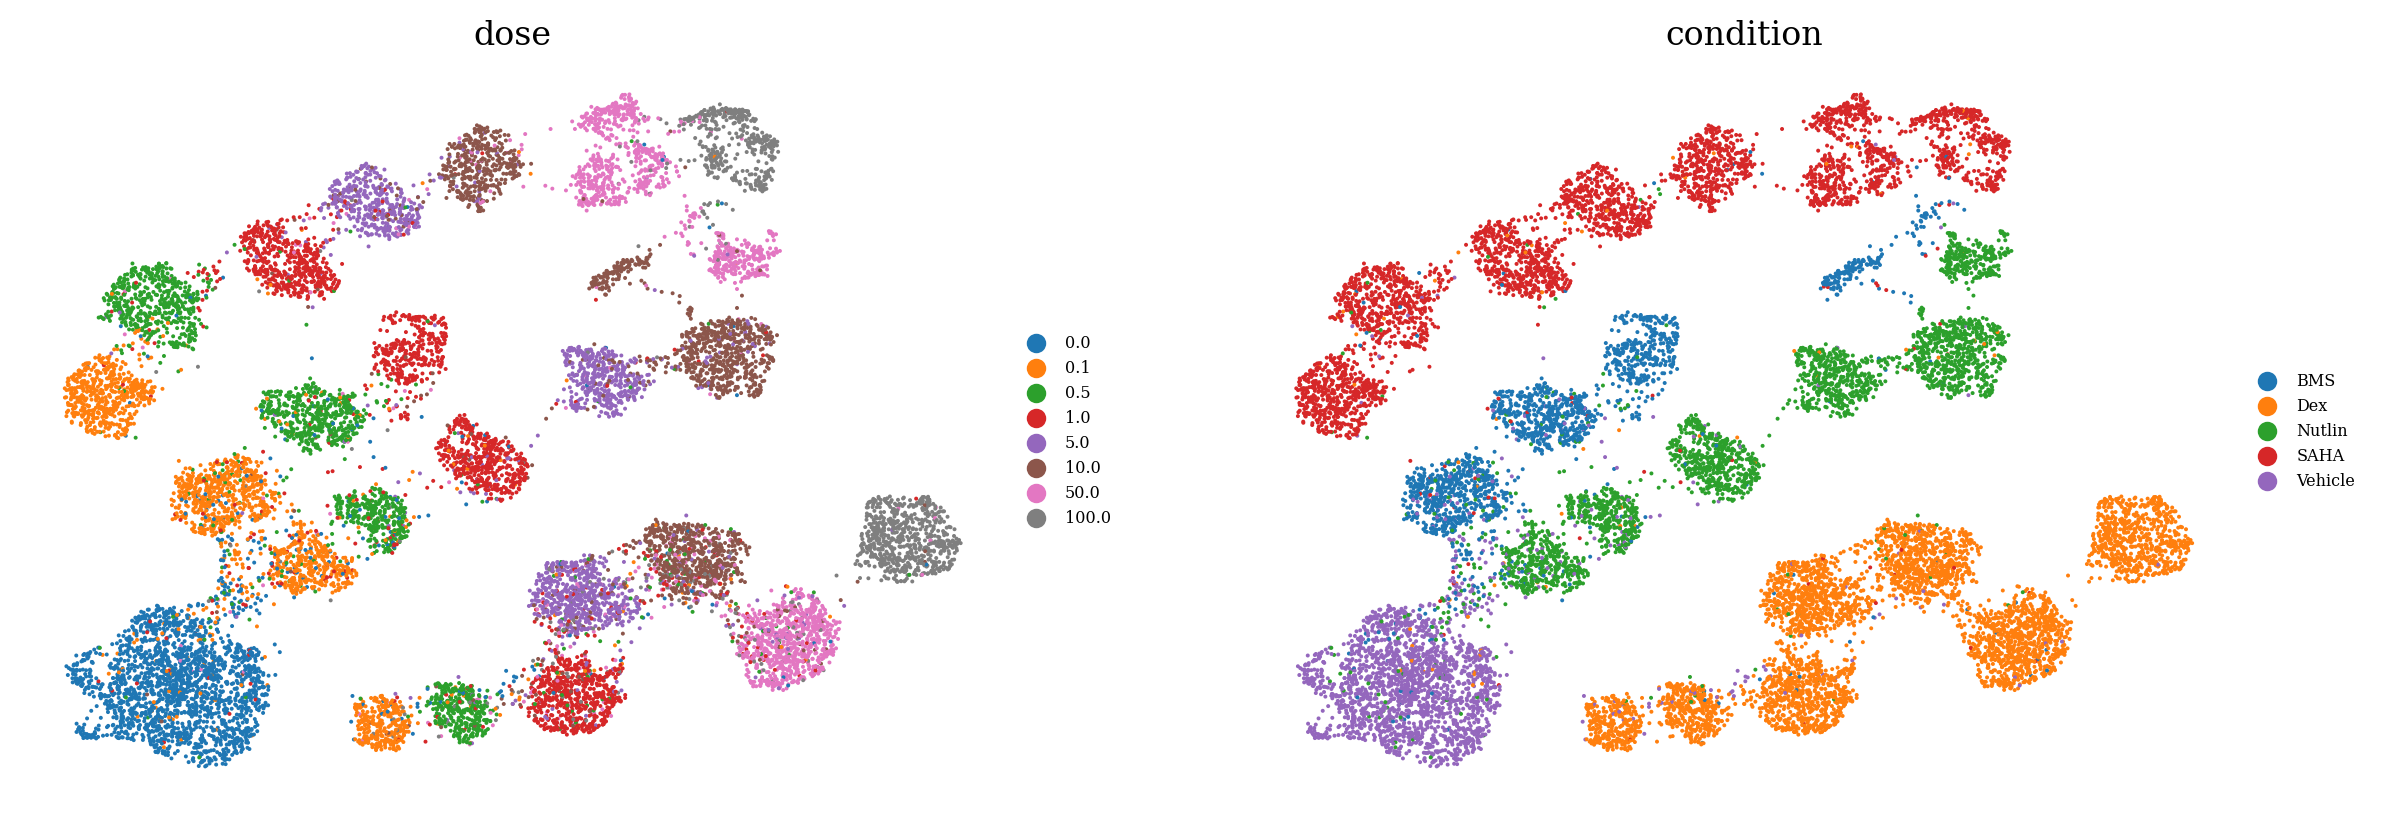

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

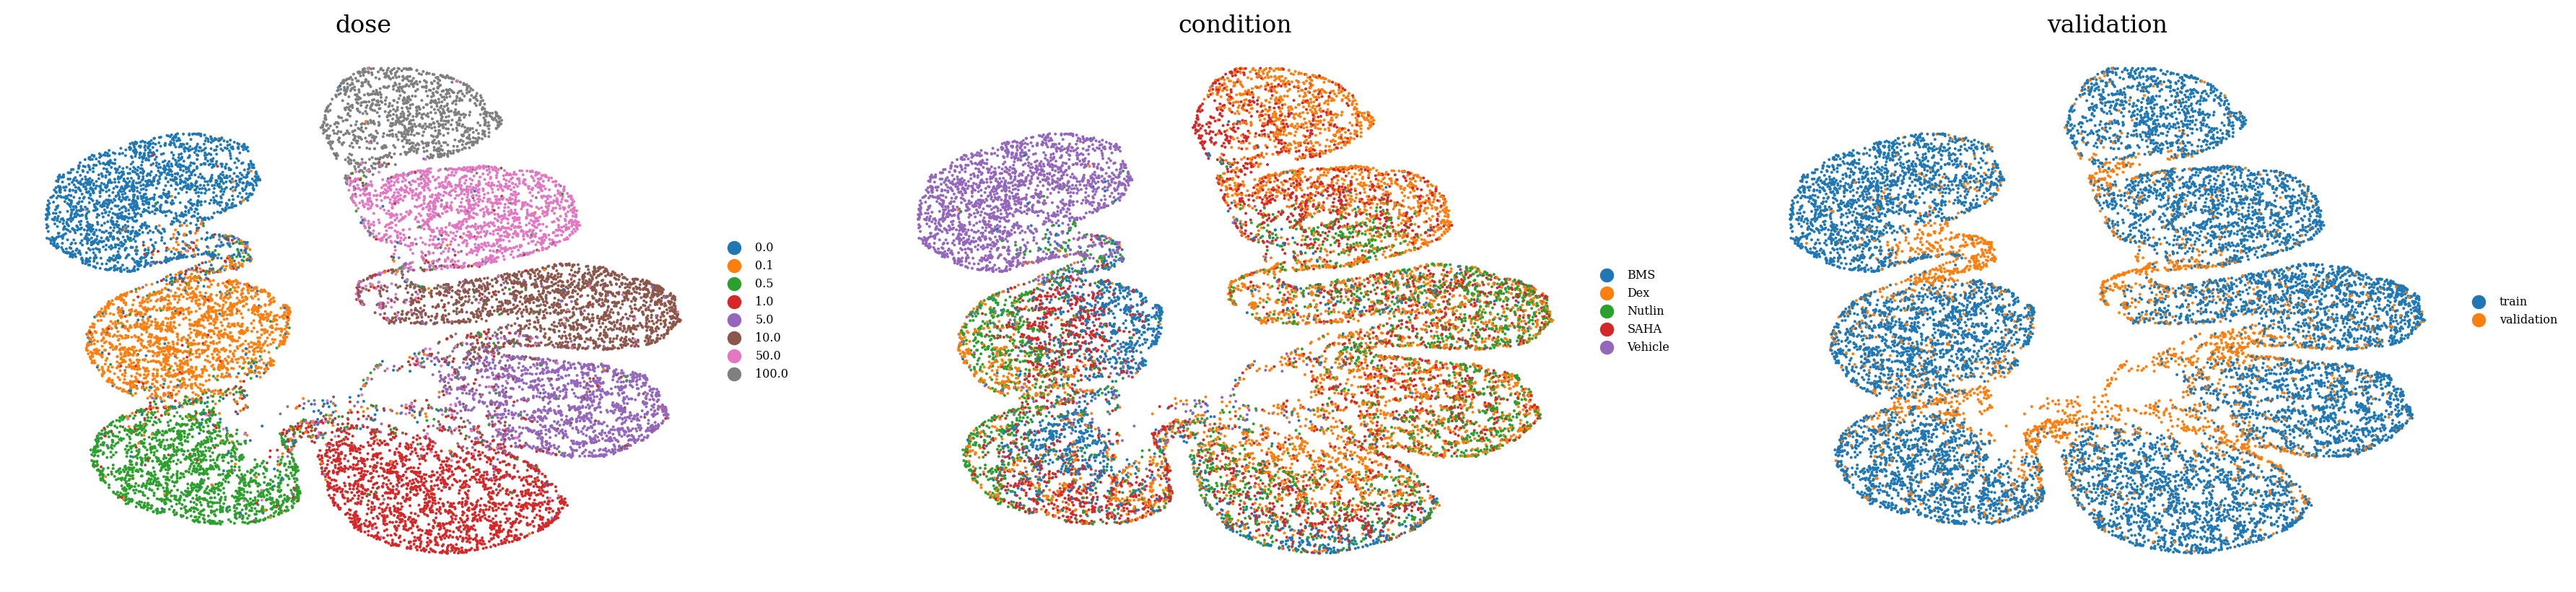

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

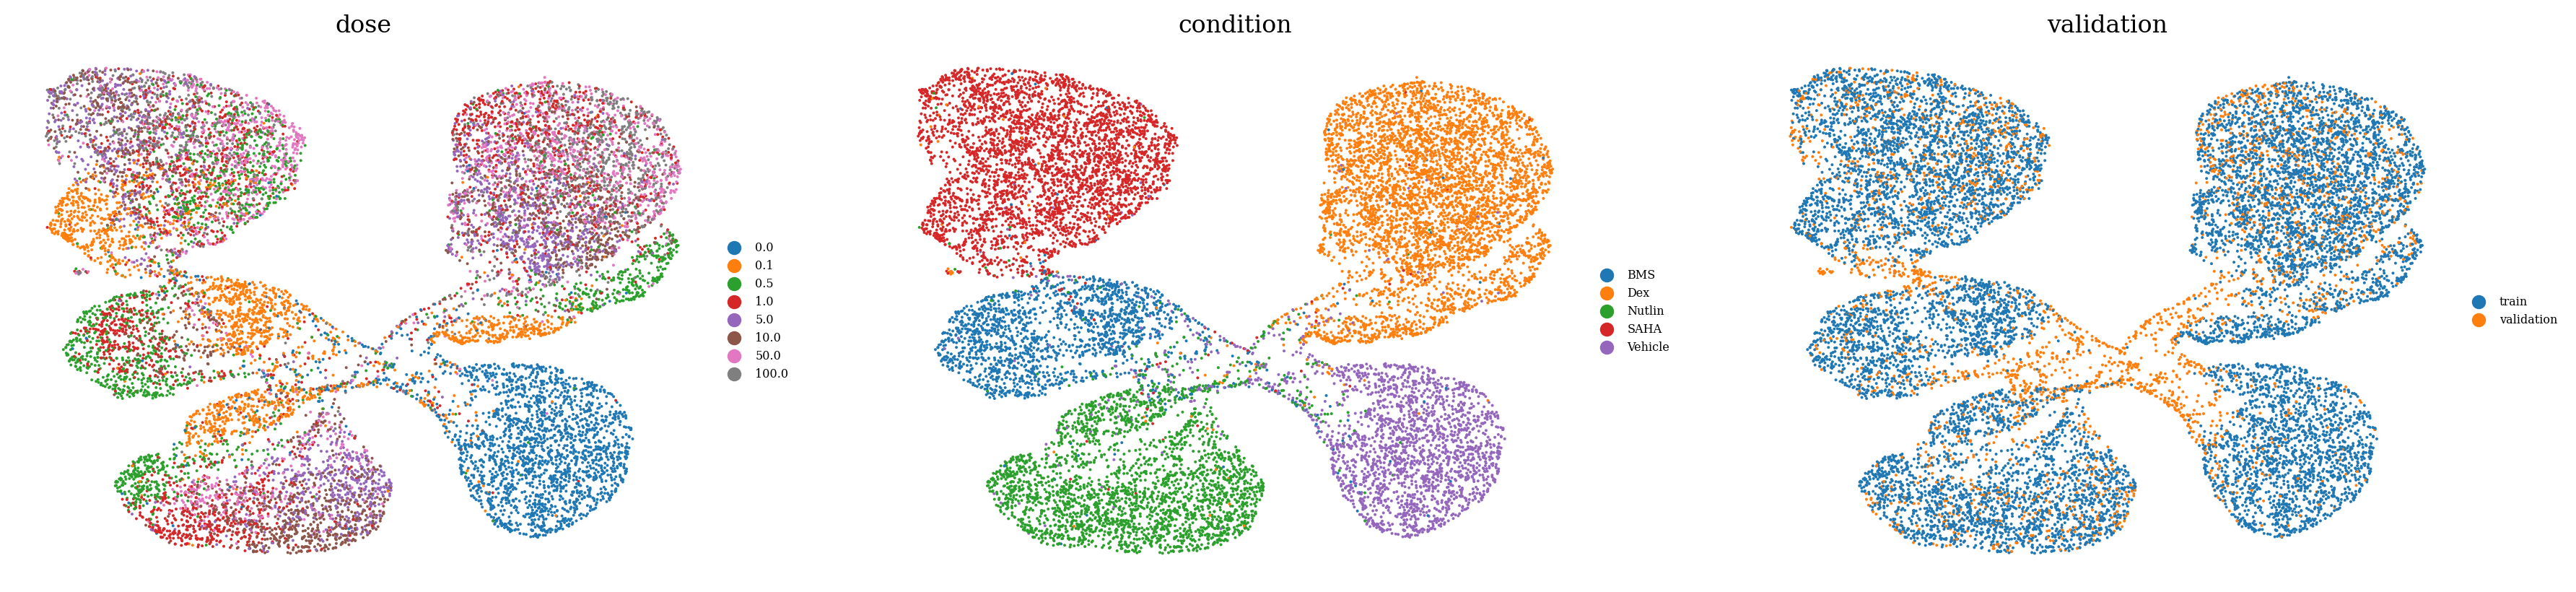

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [28]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [29]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


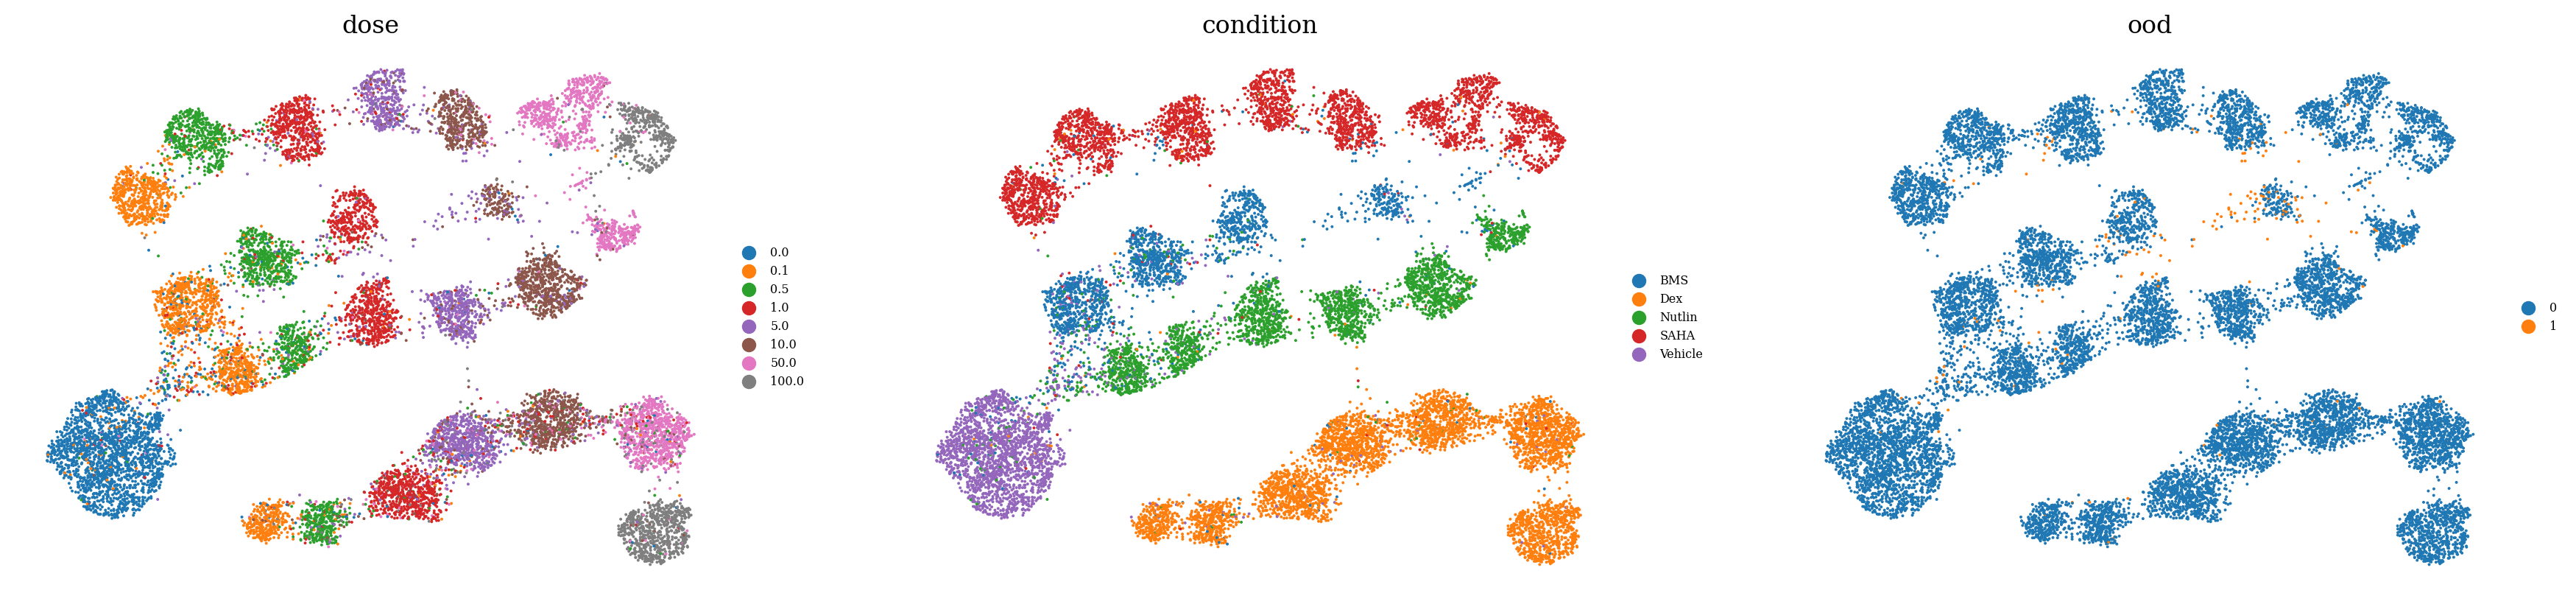

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
k = "dose_training"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


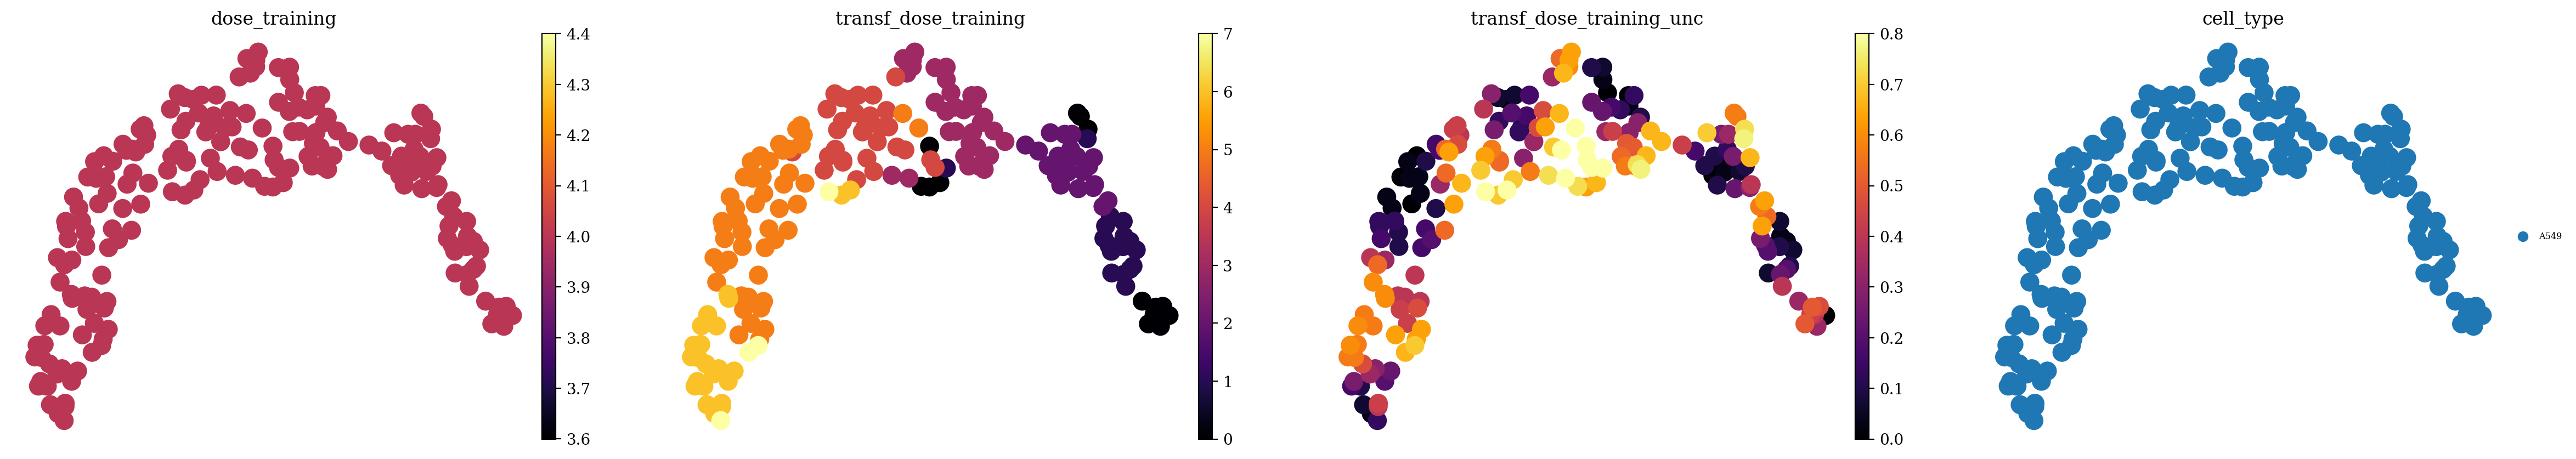

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [33]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.15544041450777202,
 'precision_macro': 0.125,
 'recall_macro': 0.019430051813471502,
 'f1_score_macro': 0.03363228699551569,
 'precision_micro': 0.15544041450777202,
 'recall_micro': 0.15544041450777202,
 'f1_score_micro': 0.15544041450777202,
 'precision_weighted': 1.0,
 'recall_weighted': 0.15544041450777202,
 'f1_score_weighted': 0.2690582959641255,
 'confusion_matrix': array([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [16, 17, 21, 33, 30, 48, 24,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])}

In [34]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [35]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.12234150293700628
